In [3]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, HTML

# For Optuna
import optuna
from optuna.visualization import (
    plot_contour,
    plot_edf,
    plot_intermediate_values,
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_timeline
)

# Optionally enable plotly for JupyterLab
try:
    import plotly.io as pio
    pio.renderers.default = "jupyterlab"
except Exception as e:
    print(f"Warning: Could not configure plotly for JupyterLab: {e}")

# Set up aesthetics for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Optuna logging settings - reduce verbosity
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
# Paths and configuration
DB_PATH = './flasc_tactis.db'

# Connect to the SQLite database
conn = sqlite3.connect(DB_PATH)
print(f"Successfully connected to database at {DB_PATH}")

# Load study from database
study_name = None  # Will be populated after querying the database

# Get the study name from the database
cursor = conn.cursor()
try:
    cursor.execute("SELECT study_name FROM studies LIMIT 1")
    study_name = cursor.fetchone()[0]
    print(f"Found study: {study_name}")
except Exception as e:
    print(f"Could not fetch study name: {e}")
    
# Load the study
try:
    study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{DB_PATH}")
    print(f"Successfully loaded study '{study_name}' with {len(study.trials)} trials")
    print(f"Best value achieved: {study.best_value}")
    print(f"Best parameters: {study.best_params}")
except Exception as e:
    print(f"Error loading study: {e}")

Successfully connected to database at ./flasc_tactis.db
Found study: tuning_tactis_tune_hb_4_3_farm_128BS_400trials
Successfully loaded study 'tuning_tactis_tune_hb_4_3_farm_128BS_400trials' with 321 trials
Best value achieved: -3081.6171875
Best parameters: {'context_length_factor': 4, 'encoder_type': 'temporal', 'marginal_embedding_dim_per_head': 256, 'marginal_num_heads': 2, 'marginal_num_layers': 2, 'flow_input_encoder_layers': 6, 'flow_series_embedding_dim': 8, 'copula_embedding_dim_per_head': 8, 'copula_num_heads': 4, 'copula_num_layers': 3, 'copula_input_encoder_layers': 4, 'copula_series_embedding_dim': 64, 'decoder_dsf_num_layers': 3, 'decoder_dsf_hidden_dim': 128, 'decoder_mlp_num_layers': 2, 'decoder_mlp_hidden_dim': 32, 'decoder_transformer_num_layers': 5, 'decoder_transformer_embedding_dim_per_head': 64, 'decoder_transformer_num_heads': 5, 'decoder_num_bins': 200, 'lr_stage1': 0.000239492693639108, 'lr_stage2': 0.0014153115740382983, 'weight_decay_stage1': 1e-05, 'weight_d

In [5]:
# Basic information about the study
print(f"Study name: {study.study_name}")
print(f"Study direction: {'MINIMIZE' if study.direction == optuna.study.StudyDirection.MINIMIZE else 'MAXIMIZE'}")
print(f"Total number of trials: {len(study.trials)}")
print(f"Number of completed trials: {len(study.get_trials(states=[optuna.trial.TrialState.COMPLETE]))}")
print(f"Number of pruned trials: {len(study.get_trials(states=[optuna.trial.TrialState.PRUNED]))}")
print(f"Number of failed trials: {len(study.get_trials(states=[optuna.trial.TrialState.FAIL]))}")

# Display best trial details
best_trial = study.best_trial
print("\nBest Trial Information:")
print(f"  Value: {best_trial.value}")
print(f"  Trial number: {best_trial.number}")
print(f"  Parameters:")
for param_name, param_value in best_trial.params.items():
    print(f"    {param_name}: {param_value}")

# Check if the study has user attributes
if study.user_attrs:
    print("\nStudy User Attributes:")
    for key, value in study.user_attrs.items():
        print(f"  {key}: {value}")

# Extract parameter names to understand the hyperparameter space
param_names = list(best_trial.params.keys())
print(f"\nHyperparameter names: {param_names}")

# Get parameter importance if scikit-learn is available
try:
    importance = optuna.importance.get_param_importances(study)
    print("\nParameter importance:")
    for param_name, score in importance.items():
        print(f"  {param_name}: {score:.4f}")
except Exception as e:
    print(f"\nCould not calculate parameter importance: {e}")

Study name: tuning_tactis_tune_hb_4_3_farm_128BS_400trials
Study direction: MINIMIZE
Total number of trials: 321
Number of completed trials: 144
Number of pruned trials: 173
Number of failed trials: 0

Best Trial Information:
  Value: -3081.6171875
  Trial number: 308
  Parameters:
    context_length_factor: 4
    encoder_type: temporal
    marginal_embedding_dim_per_head: 256
    marginal_num_heads: 2
    marginal_num_layers: 2
    flow_input_encoder_layers: 6
    flow_series_embedding_dim: 8
    copula_embedding_dim_per_head: 8
    copula_num_heads: 4
    copula_num_layers: 3
    copula_input_encoder_layers: 4
    copula_series_embedding_dim: 64
    decoder_dsf_num_layers: 3
    decoder_dsf_hidden_dim: 128
    decoder_mlp_num_layers: 2
    decoder_mlp_hidden_dim: 32
    decoder_transformer_num_layers: 5
    decoder_transformer_embedding_dim_per_head: 64
    decoder_transformer_num_heads: 5
    decoder_num_bins: 200
    lr_stage1: 0.000239492693639108
    lr_stage2: 0.0014153115740382

In [6]:
# Convert trials to DataFrame for easier analysis
def trials_to_df(study):
    """Convert Optuna study trials to a pandas DataFrame."""
    # Extract trial data
    trials_data = []
    for trial in study.trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            trial_dict = {
                'number': trial.number,
                'value': trial.value,
                'datetime_start': trial.datetime_start,
                'datetime_complete': trial.datetime_complete,
                'duration': (trial.datetime_complete - trial.datetime_start).total_seconds()
            }
            
            # Add parameters
            trial_dict.update(trial.params)
            
            # Add user attributes
            for key, value in trial.user_attrs.items():
                trial_dict[f"user_attr_{key}"] = value
            
            trials_data.append(trial_dict)
    
    # Create DataFrame
    df = pd.DataFrame(trials_data)
    
    # Sort by trial number
    df = df.sort_values('number')
    
    return df

In [7]:
# Create DataFrame
trials_df = trials_to_df(study)

# Display basic information about the DataFrame
print(f"DataFrame shape: {trials_df.shape}")
print("\nColumns:")
for col in trials_df.columns:
    print(f"  {col}")

# Display first few rows
print("\nFirst 5 rows:")
display(trials_df.head())

# Display basic statistics
print("\nBasic statistics for objective value:")
display(trials_df['value'].describe())

# Display statistics for each hyperparameter
print("\nHyperparameter statistics:")
param_cols = [col for col in trials_df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
              and not col.startswith('user_attr_')]
display(trials_df[param_cols].describe())

# Save DataFrame for later use
trials_df.to_csv('optuna_trials.csv', index=False)
print("\nSaved trials data to 'optuna_trials.csv'")

DataFrame shape: (144, 32)

Columns:
  number
  value
  datetime_start
  datetime_complete
  duration
  context_length_factor
  encoder_type
  marginal_embedding_dim_per_head
  marginal_num_heads
  marginal_num_layers
  flow_input_encoder_layers
  flow_series_embedding_dim
  copula_embedding_dim_per_head
  copula_num_heads
  copula_num_layers
  copula_input_encoder_layers
  copula_series_embedding_dim
  decoder_dsf_num_layers
  decoder_dsf_hidden_dim
  decoder_mlp_num_layers
  decoder_mlp_hidden_dim
  decoder_transformer_num_layers
  decoder_transformer_embedding_dim_per_head
  decoder_transformer_num_heads
  decoder_num_bins
  lr_stage1
  lr_stage2
  weight_decay_stage1
  weight_decay_stage2
  dropout_rate
  gradient_clip_val_stage1
  gradient_clip_val_stage2

First 5 rows:


,number,value,datetime_start,datetime_complete,duration,context_length_factor,encoder_type,marginal_embedding_dim_per_head,marginal_num_heads,marginal_num_layers,flow_input_encoder_layers,flow_series_embedding_dim,copula_embedding_dim_per_head,copula_num_heads,copula_num_layers,copula_input_encoder_layers,copula_series_embedding_dim,decoder_dsf_num_layers,decoder_dsf_hidden_dim,decoder_mlp_num_layers,decoder_mlp_hidden_dim,decoder_transformer_num_layers,decoder_transformer_embedding_dim_per_head,decoder_transformer_num_heads,decoder_num_bins,lr_stage1,lr_stage2,weight_decay_stage1,weight_decay_stage2,dropout_rate,gradient_clip_val_stage1,gradient_clip_val_stage2
0,1,-2026.978394,2025-04-25 23:28:35.302777,2025-04-26 00:11:18.153762,2562.850985,3,temporal,256,3,2,4,16,16,5,4,3,32,3,64,2,64,3,16,3,50,0.000249,0.000685,0.00000,0.00100,0.145673,0.0,0.0
1,2,-1179.029297,2025-04-25 23:28:37.508217,2025-04-26 00:14:23.165706,2745.657489,2,standard,64,2,5,6,5,128,5,3,4,16,3,512,3,48,3,256,5,50,0.000154,0.000510,0.00010,0.00000,0.111038,10000.0,0.0
2,3,-581.844971,2025-04-25 23:28:39.837268,2025-04-26 00:06:31.849125,2272.011857,2,standard,64,3,5,4,256,64,3,3,2,32,1,64,5,16,3,128,7,50,0.000131,0.000770,0.00001,0.00100,0.063789,0.0,0.0
3,9,-415.010223,2025-04-26 00:11:18.175319,2025-04-26 00:51:10.473920,2392.298601,1,temporal,128,2,3,4,5,8,5,4,2,16,4,512,2,128,2,256,5,20,0.000127,0.000745,0.00001,0.00000,0.182792,0.0,1000.0
4,10,-1005.497620,2025-04-26 00:14:23.188720,2025-04-26 00:50:35.207606,2172.018886,2,temporal,8,6,4,4,32,16,5,4,4,64,3,64,4,32,2,128,4,20,0.000456,0.001091,0.00000,0.00001,0.092585,10000.0,0.0



Basic statistics for objective value:


count     144.000000
mean    -2275.740285
std       876.117795
min     -3081.617188
25%     -2788.067017
50%     -2675.668335
75%     -2080.403687
max       789.631836
Name: value, dtype: float64


Hyperparameter statistics:


,context_length_factor,marginal_embedding_dim_per_head,marginal_num_heads,marginal_num_layers,flow_input_encoder_layers,flow_series_embedding_dim,copula_embedding_dim_per_head,copula_num_heads,copula_num_layers,copula_input_encoder_layers,copula_series_embedding_dim,decoder_dsf_num_layers,decoder_dsf_hidden_dim,decoder_mlp_num_layers,decoder_mlp_hidden_dim,decoder_transformer_num_layers,decoder_transformer_embedding_dim_per_head,decoder_transformer_num_heads,decoder_num_bins,lr_stage1,lr_stage2,weight_decay_stage1,weight_decay_stage2,dropout_rate,gradient_clip_val_stage1,gradient_clip_val_stage2
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,3.722222,215.444444,2.236111,2.166667,5.895833,18.270833,42.055556,4.152778,2.951389,3.743056,59.111111,2.958333,185.000000,2.361111,68.777778,3.972222,67.666667,6.145833,144.583333,0.000303,0.001429,0.000086,0.000109,0.098011,756.944444,1138.888889
std,0.704078,82.308798,0.689442,0.603023,0.622635,42.594563,65.675594,0.712716,0.492317,0.634074,34.750481,0.352315,174.510865,0.734857,70.357771,1.348112,52.921369,1.228842,70.272944,0.000217,0.000914,0.000211,0.000305,0.098653,2545.382568,3046.518387
min,1.000000,8.000000,2.000000,2.000000,3.000000,5.000000,8.000000,2.000000,1.000000,1.000000,16.000000,1.000000,48.000000,2.000000,8.000000,2.000000,8.000000,3.000000,20.000000,0.000110,0.000114,0.000000,0.000000,0.000037,0.000000,0.000000
25%,4.000000,256.000000,2.000000,2.000000,6.000000,5.000000,8.000000,4.000000,3.000000,4.000000,32.000000,3.000000,64.000000,2.000000,32.000000,2.000000,48.000000,6.000000,100.000000,0.000210,0.000472,0.000010,0.000000,0.017227,0.000000,0.000000
50%,4.000000,256.000000,2.000000,2.000000,6.000000,8.000000,8.000000,4.000000,3.000000,4.000000,64.000000,3.000000,64.000000,2.000000,32.000000,5.000000,64.000000,7.000000,200.000000,0.000252,0.001515,0.000010,0.000000,0.034162,0.000000,0.000000
75%,4.000000,256.000000,2.000000,2.000000,6.000000,10.000000,32.000000,4.000000,3.000000,4.000000,64.000000,3.000000,256.000000,2.250000,64.000000,5.000000,64.000000,7.000000,200.000000,0.000323,0.001980,0.000100,0.000010,0.196494,0.000000,0.000000
max,4.000000,256.000000,6.000000,5.000000,7.000000,256.000000,256.000000,6.000000,4.000000,4.000000,256.000000,4.000000,512.000000,5.000000,256.000000,5.000000,256.000000,7.000000,200.000000,0.001893,0.004842,0.001000,0.001000,0.295354,10000.000000,10000.000000



Saved trials data to 'optuna_trials.csv'


In [6]:
# Visualization using Optuna's built-in tools

# 1. Optimization History
print("## Optimization History")
print("Shows the history of the optimization process, plotting the objective value over trial numbers.")
fig = plot_optimization_history(study)
fig.update_layout(
    title="Optimization History",
    xaxis_title="Trial Number",
    yaxis_title="Objective Value",
    width=1000,
    height=600
)
fig.show()

## Optimization History
Shows the history of the optimization process, plotting the objective value over trial numbers.


In [7]:
# 2. Parameter Importances
print("\n## Parameter Importances")
print("Shows the relative importance of each hyperparameter in influencing the objective.")
try:
    fig = plot_param_importances(study)
    fig.update_layout(
        title="Parameter Importances",
        xaxis_title="Importance",
        yaxis_title="Parameter",
        width=1000,
        height=600
    )
    fig.show()
except Exception as e:
    print(f"Could not plot parameter importances: {e}")


## Parameter Importances
Shows the relative importance of each hyperparameter in influencing the objective.


In [8]:
# 3. Parallel Coordinate Plot
print("\n## Parallel Coordinate Plot")
print("Shows the relationship between hyperparameter values and objective value.")
fig = plot_parallel_coordinate(study)
fig.update_layout(
    title="Parallel Coordinate Plot",
    width=1200,
    height=700
)
fig.show()


## Parallel Coordinate Plot
Shows the relationship between hyperparameter values and objective value.


In [ ]:
# 4. Contour Plot
print("\n## Contour Plot")
print("Shows the relationship between pairs of hyperparameters and their impact on the objective.")
try:
    fig = plot_contour(study)
    fig.update_layout(
        title="Contour Plot",
        width=1200,
        height=800
    )
    fig.show()
except Exception as e:
    print(f"Could not create contour plot: {e}")

In [9]:
# 5. Slice Plot
print("\n## Slice Plot")
print("Shows the objective value as a function of each hyperparameter, while fixing others to their optimal values.")
fig = plot_slice(study)
fig.update_layout(
    title="Slice Plot",
    width=1200,
    height=800
)
fig.show()


## Slice Plot
Shows the objective value as a function of each hyperparameter, while fixing others to their optimal values.


In [10]:
# 6. EDF (Empirical Distribution Function) Plot
print("\n## EDF Plot")
print("Shows the empirical distribution of the objective values.")
fig = plot_edf(study)
fig.update_layout(
    title="Empirical Distribution Function of Objective Values",
    xaxis_title="Objective Value",
    yaxis_title="Cumulative Probability",
    width=1000,
    height=600
)
fig.show()


## EDF Plot
Shows the empirical distribution of the objective values.


In [11]:
# 7. Timeline
print("\n## Trial Timeline")
print("Shows the execution timeline of the trials.")
try:
    # This plot requires trial start/completion times
    fig = plot_timeline(study)
    fig.update_layout(
        title="Trial Timeline",
        width=1200,
        height=600
    )
    fig.show()
except Exception as e:
    print(f"Could not create timeline plot: {e}")


## Trial Timeline
Shows the execution timeline of the trials.


In [12]:
# Custom visualizations for deeper analysis

# 1. Top N best trials with parameter values
def plot_top_n_trials(df, n=10):
    """Plot the top N best performing trials along with their parameter values."""
    # Sort by objective value (assuming minimization)
    top_df = df.sort_values('value').head(n).copy()
    
    # Create a summary figure
    fig = make_subplots(
        rows=2, cols=1,
        row_heights=[0.3, 0.7],
        subplot_titles=("Objective Values for Top Trials", "Parameter Values for Top Trials")
    )
    
    # Plot objective values
    fig.add_trace(
        go.Bar(
            x=top_df['number'], 
            y=top_df['value'],
            text=top_df['value'].round(6),
            textposition='auto',
            name="Objective Value",
            marker_color='darkblue'
        ),
        row=1, col=1
    )
    
    # Get parameter columns
    param_cols = [col for col in df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                  and not col.startswith('user_attr_')]
    
    # Normalize parameter values for comparison
    for col in param_cols:
        if top_df[col].dtype in [np.float64, np.int64]:
            min_val = df[col].min()
            max_val = df[col].max()
            if max_val > min_val:  # Avoid division by zero
                top_df[f'{col}_norm'] = (top_df[col] - min_val) / (max_val - min_val)
            else:
                top_df[f'{col}_norm'] = 0.5  # Set to middle if min=max
    
    # Plot normalized parameter values
    for i, col in enumerate(param_cols):
        if f'{col}_norm' in top_df.columns:
            fig.add_trace(
                go.Scatter(
                    x=top_df['number'],
                    y=top_df[f'{col}_norm'],
                    mode='lines+markers',
                    name=col
                ),
                row=2, col=1
            )
    
    # Update layout
    fig.update_layout(
        title=f"Top {n} Trials Analysis",
        height=800,
        width=1000,
        showlegend=True,
        hovermode="x unified"
    )
    
    # Add annotations for actual parameter values
    for i, trial in top_df.iterrows():
        annotations = []
        for j, col in enumerate(param_cols):
            if f'{col}_norm' in top_df.columns:
                annotations.append(
                    f"{col}: {trial[col]}"
                )
        
        fig.add_annotation(
            x=trial['number'],
            y=1.05,  # Above the plot
            text="<br>".join(annotations),
            showarrow=False,
            xref="x2",
            yref="paper",
            align="center",
            visible=False,
            hovertext="hover"
        )
    
    return fig

In [13]:
# 2. Correlation Heatmap
def plot_correlation_heatmap(df):
    """Plot correlation between parameters and objective value."""
    # Get numeric columns including parameters and objective
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calculate correlation matrix
    corr = df[numeric_cols].corr()
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=corr.values,
        x=corr.columns,
        y=corr.index,
        colorscale='Viridis',
        zmin=-1, zmax=1
    ))
    
    # Add correlation values as text
    annotations = []
    for i, row in enumerate(corr.values):
        for j, val in enumerate(row):
            annotations.append(
                dict(
                    x=corr.columns[j],
                    y=corr.index[i],
                    text=f"{val:.2f}",
                    showarrow=False,
                    font=dict(color='white' if abs(val) > 0.5 else 'black')
                )
            )
    
    fig.update_layout(
        title="Correlation Heatmap",
        annotations=annotations,
        height=800,
        width=1000
    )
    
    return fig

In [1]:
# 3. Parameter Pairplot with Objective
def plot_pairplot_with_objective(df, params=None, n_samples=None):
    """Create a pairplot matrix of parameters colored by objective value."""
    if n_samples and n_samples < len(df):
        # Sample rows if dataset is large
        df_sample = df.sample(n_samples, random_state=42)
    else:
        df_sample = df.copy()
    
    # Select parameters to plot
    if params is None:
        param_cols = [col for col in df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                      and not col.startswith('user_attr_')]
        # Limit to top 6 parameters if there are many
        if len(param_cols) > 6:
            try:
                importance = optuna.importance.get_param_importances(study)
                param_cols = list(importance.keys())[:6]
            except:
                param_cols = param_cols[:6]
    else:
        param_cols = params
    
    # Add objective value for coloring
    plot_df = df_sample[param_cols + ['value']].copy()
    
    # Find best trial for highlighting
    best_trial_idx = df['value'].idxmin()
    
    # Add a column to identify the best trial
    df_sample['is_best'] = False
    if best_trial_idx in df_sample.index:
        df_sample.loc[best_trial_idx, 'is_best'] = True
    else:
        # If best trial isn't in the sample, add it
        best_trial = df.loc[[best_trial_idx]].copy()
        best_trial['is_best'] = True
        df_sample = pd.concat([df_sample, best_trial])
    
    # Create a separate dataframe with only the best trial
    best_df = df_sample[df_sample['is_best']]
    
    # Create pairplot figure using plotly
    fig = px.scatter_matrix(
        plot_df,
        dimensions=param_cols,
        color='value',
        color_continuous_scale=px.colors.sequential.Viridis,
        title="Parameter Pairplot Colored by Objective Value"
    )
    
    # Update layout
    fig.update_layout(
        height=900,
        width=1100
    )
    
    # Instead of highlighting directly with add_trace, 
    # use a different approach to overlay the best trial
    # Scatter matrix indices are tricky, so create a
    # completely separate scatter_matrix for just the best point
    
    # Create a custom legend entry for the best trial
    fig.add_trace(
        go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(
                color='red',
                size=10,
                line=dict(color='black', width=2)
            ),
            name='Best Trial',
            showlegend=True
        )
    )
    
    # Update scatter points to show best trial more prominently
    for i in range(len(fig.data)):
        if hasattr(fig.data[i], 'marker'):
            # Add custom marker for best trial points
            fig.data[i].marker.size = 7
            # Add size array with larger size for best trial
            if 'customdata' in fig.data[i] and fig.data[i].customdata is not None:
                # Create size array based on whether it's the best trial
                sizes = [15 if df.loc[best_trial_idx, 'value'] == val[0] else 7 
                         for val in fig.data[i].customdata]
                fig.data[i].marker.size = sizes
                
                # Also change the color of the best trial points
                colors = [
                    '#FF0000' if df.loc[best_trial_idx, 'value'] == val[0] else None
                    for val in fig.data[i].customdata
                ]
                # Set outlier colors
                for j, color in enumerate(colors):
                    if color:
                        if not hasattr(fig.data[i].marker, 'outliercolor'):
                            fig.data[i].marker['outliercolor'] = []
                        while len(fig.data[i].marker['outliercolor']) <= j:
                            fig.data[i].marker['outliercolor'].append(None)
                        fig.data[i].marker['outliercolor'][j] = color
    
    return fig

In [15]:
# 4. Objective Value Distribution
def plot_objective_distribution(df):
    """Plot the distribution of objective values."""
    fig = make_subplots(rows=1, cols=2, 
                        subplot_titles=("Histogram of Objective Values", "Box Plot of Objective Values"),
                        specs=[[{"type": "xy"}, {"type": "box"}]])
    
    # Histogram
    fig.add_trace(
        go.Histogram(
            x=df['value'],
            nbinsx=30,
            marker_color='blue',
            opacity=0.7,
            name="Distribution"
        ),
        row=1, col=1
    )
    
    # Add vertical line for best value
    best_value = df['value'].min()
    fig.add_vline(
        x=best_value,
        line_dash="dash",
        line_color="red",
        row=1, col=1
    )
    
    # Add annotation for best value
    fig.add_annotation(
        x=best_value,
        y=0,
        text=f"Best: {best_value:.6f}",
        showarrow=True,
        arrowhead=1,
        row=1, col=1
    )
    
    # Box plot
    fig.add_trace(
        go.Box(
            y=df['value'],
            marker_color='blue',
            name="Objective"
        ),
        row=1, col=2
    )
    
    # Update layout
    fig.update_layout(
        title="Distribution of Objective Values",
        height=500,
        width=1000
    )
    
    return fig

In [16]:
# 5. Parameter Value Distribution
def plot_parameter_distributions(df, top_n_params=None):
    """Plot distribution of parameter values."""
    # Get parameter columns
    param_cols = [col for col in df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                  and not col.startswith('user_attr_')]
    
    # Select top parameters if requested
    if top_n_params and len(param_cols) > top_n_params:
        try:
            importance = optuna.importance.get_param_importances(study)
            param_cols = list(importance.keys())[:top_n_params]
        except:
            param_cols = param_cols[:top_n_params]
    
    # Calculate number of rows and columns for subplots
    n_params = len(param_cols)
    n_cols = min(3, n_params)
    n_rows = (n_params + n_cols - 1) // n_cols
    
    # Create subplots
    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        subplot_titles=param_cols
    )
    
    # Add histograms for each parameter
    for i, param in enumerate(param_cols):
        row = i // n_cols + 1
        col = i % n_cols + 1
        
        # Check if parameter is categorical
        if df[param].dtype == 'object' or (df[param].dtype == 'int64' and len(df[param].unique()) < 10):
            # Create bar chart for categorical parameters
            counts = df[param].value_counts().reset_index()
            counts.columns = ['value', 'count']
            
            fig.add_trace(
                go.Bar(
                    x=counts['value'],
                    y=counts['count'],
                    name=param
                ),
                row=row, col=col
            )
        else:
            # Create histogram for numerical parameters
            fig.add_trace(
                go.Histogram(
                    x=df[param],
                    nbinsx=20,
                    name=param
                ),
                row=row, col=col
            )
            
        # Add marker for value in best trial
        best_trial_idx = df['value'].idxmin()
        best_param_value = df.loc[best_trial_idx, param]
        
        # Add vertical line for best value
        fig.add_vline(
            x=best_param_value,
            line_dash="dash",
            line_color="red",
            row=row, col=col
        )
    
    # Update layout
    fig.update_layout(
        title="Distribution of Parameter Values (Red line: value in best trial)",
        height=300 * n_rows,
        width=1000,
        showlegend=False
    )
    
    return fig

In [17]:
# 6. Objective value vs. trial duration
def plot_objective_vs_duration(df):
    """Plot objective value versus trial duration."""
    fig = go.Figure()
    
    # Scatter plot
    fig.add_trace(
        go.Scatter(
            x=df['duration'],
            y=df['value'],
            mode='markers',
            marker=dict(
                size=10,
                color=df['number'],  # Color by trial number
                colorscale='Viridis',
                colorbar=dict(title="Trial Number"),
                opacity=0.8
            ),
            text=df['number'].apply(lambda x: f"Trial {x}"),
            hovertemplate="<b>%{text}</b><br>Duration: %{x:.2f}s<br>Value: %{y:.6f}<extra></extra>"
        )
    )
    
    # Highlight best trial
    best_trial_idx = df['value'].idxmin()
    fig.add_trace(
        go.Scatter(
            x=[df.loc[best_trial_idx, 'duration']],
            y=[df.loc[best_trial_idx, 'value']],
            mode='markers',
            marker=dict(
                size=15,
                color='red',
                symbol='star',
                line=dict(width=2, color='black')
            ),
            name="Best Trial"
        )
    )
    
    # Add trend line
    try:
        z = np.polyfit(df['duration'], df['value'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(df['duration'].min(), df['duration'].max(), 100)
        fig.add_trace(
            go.Scatter(
                x=x_trend,
                y=p(x_trend),
                mode='lines',
                line=dict(color='rgba(255, 0, 0, 0.5)', width=2),
                name="Trend Line"
            )
        )
    except:
        pass
    
    # Update layout
    fig.update_layout(
        title="Objective Value vs. Trial Duration",
        xaxis_title="Trial Duration (seconds)",
        yaxis_title="Objective Value",
        height=600,
        width=1000
    )
    
    return fig

In [18]:
# 7. Parameter value search evolution
def plot_parameter_evolution(df, top_n_params=None):
    """Plot the evolution of parameter values over trials."""
    # Get parameter columns
    param_cols = [col for col in df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                  and not col.startswith('user_attr_')]
    
    # Select top parameters if requested
    if top_n_params and len(param_cols) > top_n_params:
        try:
            importance = optuna.importance.get_param_importances(study)
            param_cols = list(importance.keys())[:top_n_params]
        except:
            param_cols = param_cols[:top_n_params]
    
    # Create figure
    fig = make_subplots(
        rows=len(param_cols), cols=1,
        subplot_titles=param_cols,
        shared_xaxes=True,
        vertical_spacing=0.03
    )
    
    # Sort by trial number
    df_sorted = df.sort_values('number')
    
    # Add traces for each parameter
    for i, param in enumerate(param_cols):
        # Normalize parameter values for better visualization
        if df_sorted[param].dtype in [np.float64, np.int64]:
            min_val = df_sorted[param].min()
            max_val = df_sorted[param].max()
            if max_val > min_val:  # Avoid division by zero
                norm_values = (df_sorted[param] - min_val) / (max_val - min_val)
            else:
                norm_values = np.ones(len(df_sorted))
            
            # Add scatter plot for parameter values
            fig.add_trace(
                go.Scatter(
                    x=df_sorted['number'],
                    y=norm_values,
                    mode='lines+markers',
                    name=param,
                    text=df_sorted[param],
                    hovertemplate="Trial %{x}<br>" + param + ": %{text}<extra></extra>",
                    marker=dict(size=8)
                ),
                row=i+1, col=1
            )
            
            # Add second y-axis with actual parameter values
            fig.update_yaxes(
                title_text="Normalized Value",
                row=i+1, col=1,
                range=[0, 1]
            )
        else:
            # For categorical parameters, just plot the values
            fig.add_trace(
                go.Scatter(
                    x=df_sorted['number'],
                    y=df_sorted[param],
                    mode='lines+markers',
                    name=param,
                    marker=dict(size=8)
                ),
                row=i+1, col=1
            )
    
    # Add objective value as color
    for i, param in enumerate(param_cols):
        fig.add_trace(
            go.Scatter(
                x=df_sorted['number'],
                y=np.ones(len(df_sorted)) * 0.5,  # Middle of the plot
                mode='markers',
                marker=dict(
                    size=12,
                    color=df_sorted['value'],
                    colorscale='Viridis',
                    colorbar=dict(title="Objective Value"),
                    showscale=i == 0,  # Show colorbar only for first parameter
                    opacity=0.7
                ),
                hoverinfo='skip',
                showlegend=False
            ),
            row=i+1, col=1
        )
    
    # Update layout
    fig.update_layout(
        title="Evolution of Parameter Values Across Trials",
        xaxis_title="Trial Number",
        height=200 * len(param_cols),
        width=1000,
        showlegend=False
    )
    
    return fig

In [19]:
# Create and display plots
print("## Top 10 Best Trials")
fig = plot_top_n_trials(trials_df, n=10)
fig.show()

## Top 10 Best Trials


In [20]:
print("\n## Correlation Heatmap")
fig = plot_correlation_heatmap(trials_df)
fig.show()


## Correlation Heatmap


In [8]:
print("\n## Parameter Pairplot")
fig = plot_pairplot_with_objective(trials_df, n_samples=100)
fig.show()


## Parameter Pairplot


In [22]:
print("\n## Objective Value Distribution")
fig = plot_objective_distribution(trials_df)
fig.show()


## Objective Value Distribution


In [23]:
print("\n## Parameter Value Distributions")
fig = plot_parameter_distributions(trials_df, top_n_params=6)
fig.show()


## Parameter Value Distributions


In [24]:
print("\n## Objective Value vs. Trial Duration")
fig = plot_objective_vs_duration(trials_df)
fig.show()


## Objective Value vs. Trial Duration


In [25]:
print("\n## Parameter Value Evolution")
fig = plot_parameter_evolution(trials_df, top_n_params=6)
fig.show()


## Parameter Value Evolution


In [10]:
# Interactive analysis using ipywidgets

# 1. Interactive parameter importance threshold selector
def create_importance_threshold_widget():
    """Create a widget to interactively adjust the threshold for parameter importance."""
    # Get parameter importance
    try:
        importance = optuna.importance.get_param_importances(study)
        
        # Create widget
        threshold_slider = widgets.FloatSlider(
            value=0.01,
            min=0.0,
            max=0.5,
            step=0.01,
            description='Threshold:',
            continuous_update=False
        )
        
        # Define output function
        out = widgets.Output()
        
        def update_plot(change):
            with out:
                out.clear_output(wait=True)
                
                # Filter parameters by importance
                filtered_importance = {k: v for k, v in importance.items() if v >= threshold_slider.value}
                
                if not filtered_importance:
                    print("No parameters meet the threshold. Please lower the threshold.")
                    return
                
                # Create bar chart
                params = list(filtered_importance.keys())
                values = list(filtered_importance.values())
                
                fig = go.Figure(data=[
                    go.Bar(
                        x=values,
                        y=params,
                        orientation='h',
                        marker_color='navy'
                    )
                ])
                
                fig.update_layout(
                    title=f"Parameter Importance (Threshold: {threshold_slider.value:.2f})",
                    xaxis_title="Importance Score",
                    yaxis_title="Parameter",
                    height=400 + len(params) * 20,
                    width=800
                )
                
                fig.show()
        
        # Register callback
        threshold_slider.observe(update_plot, names='value')
        
        # Initialize plot
        update_plot(None)
        
        # Display widget and output
        display(widgets.VBox([threshold_slider, out]))
        
    except Exception as e:
        print(f"Could not create importance threshold widget: {e}")

In [11]:
# 2. Interactive parameter filter for trial viewer
def create_parameter_filter_widget():
    """Create widgets to filter trials based on parameter values."""
    # Get parameter columns
    param_cols = [col for col in trials_df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                  and not col.startswith('user_attr_')]
    
    # Create widgets for each parameter
    param_widgets = {}
    for param in param_cols:
        # Check parameter type
        if trials_df[param].dtype in [np.float64, np.int64]:
            # Numerical parameter - use range slider
            min_val = trials_df[param].min()
            max_val = trials_df[param].max()
            step = (max_val - min_val) / 100
            if trials_df[param].dtype == np.int64:
                step = max(1, int(step))
            
            param_widgets[param] = widgets.FloatRangeSlider(
                value=[min_val, max_val],
                min=min_val,
                max=max_val,
                step=step,
                description=f'{param}:',
                continuous_update=False,
                layout=widgets.Layout(width='600px')
            )
        else:
            # Categorical parameter - use multiple selection
            options = trials_df[param].unique().tolist()
            param_widgets[param] = widgets.SelectMultiple(
                options=options,
                value=options,
                description=f'{param}:',
                layout=widgets.Layout(width='600px', height='100px')
            )
    
    # Create "Top N trials" selector
    top_n = widgets.IntSlider(
        value=10,
        min=1,
        max=50,
        step=1,
        description='Top N:',
        continuous_update=False
    )
    
    # Create button to apply filters
    apply_button = widgets.Button(
        description='Apply Filters',
        button_style='primary',
        icon='filter'
    )
    
    # Create output area
    out = widgets.Output()
    
    # Define filter function
    def apply_filters(b):
        with out:
            out.clear_output(wait=True)
            
            # Start with all trials
            filtered_df = trials_df.copy()
            
            # Apply parameter filters
            for param, widget in param_widgets.items():
                if isinstance(widget, widgets.FloatRangeSlider):
                    min_val, max_val = widget.value
                    filtered_df = filtered_df[(filtered_df[param] >= min_val) & (filtered_df[param] <= max_val)]
                elif isinstance(widget, widgets.SelectMultiple):
                    if widget.value:  # If some options are selected
                        filtered_df = filtered_df[filtered_df[param].isin(widget.value)]
            
            # Display summary
            print(f"Filtered to {len(filtered_df)} trials out of {len(trials_df)} total trials")
            
            # Display top N trials
            top_filtered = filtered_df.sort_values('value').head(top_n.value)
            
            if len(top_filtered) > 0:
                print(f"\nTop {len(top_filtered)} trials after filtering:")
                display(top_filtered[['number', 'value'] + param_cols])
                
                # Plot top N trials
                fig = make_subplots(rows=1, cols=1)
                
                fig.add_trace(
                    go.Bar(
                        x=top_filtered['number'],
                        y=top_filtered['value'],
                        text=top_filtered['value'].round(6),
                        textposition='auto',
                        marker_color='darkblue',
                        name="Objective Value"
                    )
                )
                
                fig.update_layout(
                    title=f"Top {len(top_filtered)} Trials After Filtering",
                    xaxis_title="Trial Number",
                    yaxis_title="Objective Value",
                    height=500,
                    width=900
                )
                
                fig.show()
            else:
                print("No trials match the filter criteria. Please adjust the filters.")
    
    # Register callback
    apply_button.on_click(apply_filters)
    
    # Create reset button
    reset_button = widgets.Button(
        description='Reset Filters',
        button_style='warning',
        icon='refresh'
    )
    
    # Define reset function
    def reset_filters(b):
        for param, widget in param_widgets.items():
            if isinstance(widget, widgets.FloatRangeSlider):
                widget.value = [widget.min, widget.max]
            elif isinstance(widget, widgets.SelectMultiple):
                widget.value = widget.options
        
        # Also clear output
        with out:
            out.clear_output(wait=True)
            print("Filters reset. Click 'Apply Filters' to view all trials.")
    
    # Register callback
    reset_button.on_click(reset_filters)
    
    # Create widget layout
    param_box = widgets.VBox([widgets.Label("Parameter Filters:")] + 
                             [widgets.VBox([widget]) for widget in param_widgets.values()])
    
    control_box = widgets.HBox([top_n, apply_button, reset_button])
    
    # Display all widgets
    display(widgets.VBox([param_box, control_box, out]))
    
    # Initial call to show data
    apply_filters(None)

In [12]:
# 3. Interactive trial comparator
def create_trial_comparator_widget():
    """Create a widget to compare two trials side by side."""
    # Get list of trials
    trial_numbers = trials_df['number'].tolist()
    
    # Create trial selector widgets
    trial1 = widgets.Dropdown(
        options=trial_numbers,
        value=trial_numbers[0],
        description='Trial 1:',
        layout=widgets.Layout(width='200px')
    )
    
    trial2 = widgets.Dropdown(
        options=trial_numbers,
        value=study.best_trial.number,
        description='Trial 2:',
        layout=widgets.Layout(width='200px')
    )
    
    # Create button to compare
    compare_button = widgets.Button(
        description='Compare',
        button_style='primary',
        icon='exchange'
    )
    
    # Create output area
    out = widgets.Output()
    
    # Define comparison function
    def compare_trials(b):
        with out:
            out.clear_output(wait=True)
            
            # Get trials
            t1 = trials_df[trials_df['number'] == trial1.value].iloc[0]
            t2 = trials_df[trials_df['number'] == trial2.value].iloc[0]
            
            # Create comparison table
            comparison_data = []
            
            # Add objective value
            comparison_data.append({
                'Parameter': 'Objective Value',
                'Trial 1': t1['value'],
                'Trial 2': t2['value'],
                'Difference': t2['value'] - t1['value'],
                'Percent Change': (t2['value'] - t1['value']) / abs(t1['value']) * 100 if t1['value'] != 0 else float('inf')
            })
            
            # Add parameters
            param_cols = [col for col in trials_df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                          and not col.startswith('user_attr_')]
            
            for param in param_cols:
                p1 = t1[param]
                p2 = t2[param]
                
                if isinstance(p1, (int, float)) and isinstance(p2, (int, float)):
                    diff = p2 - p1
                    pct = (p2 - p1) / abs(p1) * 100 if p1 != 0 else float('inf')
                else:
                    diff = "N/A"
                    pct = "N/A"
                
                comparison_data.append({
                    'Parameter': param,
                    'Trial 1': p1,
                    'Trial 2': p2,
                    'Difference': diff,
                    'Percent Change': pct
                })
            
            # Create DataFrame
            comparison_df = pd.DataFrame(comparison_data)
            
            # Display comparison
            display(HTML(f"<h3>Comparison between Trial {trial1.value} and Trial {trial2.value}</h3>"))
            display(comparison_df)
            
            # Create bar chart to visualize differences
            numeric_params = [p for p in param_cols if isinstance(t1[p], (int, float)) and isinstance(t2[p], (int, float))]
            
            # Normalize parameter values for better visualization
            normalized_data = []
            for param in numeric_params:
                # Get min/max across all trials for this parameter
                min_val = trials_df[param].min()
                max_val = trials_df[param].max()
                
                if max_val > min_val:  # Avoid division by zero
                    norm_p1 = (t1[param] - min_val) / (max_val - min_val)
                    norm_p2 = (t2[param] - min_val) / (max_val - min_val)
                    
                    normalized_data.append({
                        'Parameter': param,
                        'Trial 1': norm_p1,
                        'Trial 2': norm_p2,
                        'Original 1': t1[param],
                        'Original 2': t2[param]
                    })
            
            # Create subplot
            fig = make_subplots(rows=1, cols=2, 
                                subplot_titles=("Normalized Parameter Values", "Objective Value"),
                                specs=[[{"type": "bar"}, {"type": "bar"}]])
            
            # Parameter comparison
            norm_df = pd.DataFrame(normalized_data)
            
            fig.add_trace(
                go.Bar(
                    y=norm_df['Parameter'],
                    x=norm_df['Trial 1'],
                    name=f'Trial {trial1.value}',
                    orientation='h',
                    marker_color='blue',
                    text=norm_df['Original 1'],
                    hovertemplate='%{y}: %{text}<extra></extra>'
                ),
                row=1, col=1
            )
            
            fig.add_trace(
                go.Bar(
                    y=norm_df['Parameter'],
                    x=norm_df['Trial 2'],
                    name=f'Trial {trial2.value}',
                    orientation='h',
                    marker_color='red',
                    text=norm_df['Original 2'],
                    hovertemplate='%{y}: %{text}<extra></extra>'
                ),
                row=1, col=1
            )
            
            # Objective value comparison
            fig.add_trace(
                go.Bar(
                    x=['Objective'],
                    y=[t1['value']],
                    name=f'Trial {trial1.value}',
                    marker_color='blue'
                ),
                row=1, col=2
            )
            
            fig.add_trace(
                go.Bar(
                    x=['Objective'],
                    y=[t2['value']],
                    name=f'Trial {trial2.value}',
                    marker_color='red'
                ),
                row=1, col=2
            )
            
            # Update layout
            fig.update_layout(
                title=f"Comparison between Trial {trial1.value} and Trial {trial2.value}",
                barmode='group',
                height=500 + len(numeric_params) * 20,
                width=1000
            )
            
            fig.show()
    
    # Register callback
    compare_button.on_click(compare_trials)
    
    # Create a "best trial" button
    best_button = widgets.Button(
        description='Compare with Best',
        button_style='success',
        icon='star'
    )
    
    # Define best trial function
    def compare_with_best(b):
        trial2.value = study.best_trial.number
        compare_trials(None)
    
    # Register callback
    best_button.on_click(compare_with_best)
    
    # Create widget layout
    control_box = widgets.HBox([trial1, trial2, compare_button, best_button])
    
    # Display all widgets
    display(widgets.VBox([control_box, out]))
    
    # Initial call to show data
    compare_trials(None)

In [13]:
# 4. Parameter importance analysis
def create_param_importance_analyzer():
    """Create interactive widget to analyze parameter importance."""
    try:
        # Get parameter importance
        importance = optuna.importance.get_param_importances(study)
        
        # Create selecting widget for evaluator
        evaluator = widgets.Dropdown(
            options=[
                'Default', 
                'Fanova', 
                'Mean Decrease Impurity', 
                'PedAnova'
            ],
            value='Default',
            description='Evaluator:',
            layout=widgets.Layout(width='300px')
        )
        
        # Create button to recalculate
        recalc_button = widgets.Button(
            description='Recalculate',
            button_style='primary',
            icon='refresh'
        )
        
        # Create output area
        out = widgets.Output()
        
        # Define recalculation function
        def recalculate(b):
            with out:
                out.clear_output(wait=True)
                
                print("Calculating parameter importance...")
                
                # Select evaluator
                if evaluator.value == 'Default':
                    imp_evaluator = None
                elif evaluator.value == 'Fanova':
                    from optuna.importance import FanovaImportanceEvaluator
                    imp_evaluator = FanovaImportanceEvaluator()
                elif evaluator.value == 'Mean Decrease Impurity':
                    from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
                    imp_evaluator = MeanDecreaseImpurityImportanceEvaluator()
                elif evaluator.value == 'PedAnova':
                    from optuna.importance import PedAnovaImportanceEvaluator
                    imp_evaluator = PedAnovaImportanceEvaluator()
                
                try:
                    # Calculate importance
                    if imp_evaluator:
                        importance = optuna.importance.get_param_importances(study, evaluator=imp_evaluator)
                    else:
                        importance = optuna.importance.get_param_importances(study)
                    
                    # Create bar chart
                    params = list(importance.keys())
                    values = list(importance.values())
                    
                    fig = go.Figure(data=[
                        go.Bar(
                            x=values,
                            y=params,
                            orientation='h',
                            marker_color='navy'
                        )
                    ])
                    
                    fig.update_layout(
                        title=f"Parameter Importance using {evaluator.value} Evaluator",
                        xaxis_title="Importance Score",
                        yaxis_title="Parameter",
                        height=400 + len(params) * 20,
                        width=800
                    )
                    
                    fig.show()
                    
                    # Show importance table
                    importance_df = pd.DataFrame({
                        'Parameter': params,
                        'Importance': values
                    }).sort_values('Importance', ascending=False)
                    
                    print("\nParameter Importance Values:")
                    display(importance_df)
                    
                except Exception as e:
                    print(f"Error calculating importance: {e}")
        
        # Register callback
        recalc_button.on_click(recalculate)
        
        # Create widget layout
        control_box = widgets.HBox([evaluator, recalc_button])
        
        # Display all widgets
        display(widgets.VBox([control_box, out]))
        
        # Initial call to show data
        recalculate(None)
        
    except Exception as e:
        print(f"Could not create parameter importance analyzer: {e}")

In [14]:
# Display the interactive widgets
print("## Interactive Parameter Importance Threshold")
print("Use the slider to adjust the threshold for displaying parameter importance.")
create_importance_threshold_widget()

## Interactive Parameter Importance Threshold
Use the slider to adjust the threshold for displaying parameter importance.


In [15]:
print("\n## Interactive Trial Filter")
print("Filter trials based on parameter values to find the best performing trials within specific parameter ranges.")
create_parameter_filter_widget()


## Interactive Trial Filter
Filter trials based on parameter values to find the best performing trials within specific parameter ranges.


In [16]:
print("\n## Interactive Trial Comparator")
print("Compare any two trials side by side to analyze differences in parameters and performance.")
create_trial_comparator_widget()


## Interactive Trial Comparator
Compare any two trials side by side to analyze differences in parameters and performance.


In [17]:
print("\n## Parameter Importance Analyzer")
print("Analyze parameter importance using different evaluation techniques.")
create_param_importance_analyzer()


## Parameter Importance Analyzer
Analyze parameter importance using different evaluation techniques.


In [18]:
# Advanced Hyperparameter Analysis

# 1. Learning Curves Analysis
def analyze_learning_curves():
    """Analyze the learning curves of the optimization process."""
    # Sort trials by execution order
    sorted_trials = sorted(study.trials, key=lambda t: t.number)
    
    # Extract data
    trial_numbers = []
    best_values = []
    values = []
    
    best_so_far = float('inf')  # Assuming minimization
    for trial in sorted_trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            trial_numbers.append(trial.number)
            values.append(trial.value)
            
            # Update best value
            if trial.value < best_so_far:
                best_so_far = trial.value
            
            best_values.append(best_so_far)
    
    # Create plot
    fig = go.Figure()
    
    # Add all trials
    fig.add_trace(
        go.Scatter(
            x=trial_numbers,
            y=values,
            mode='markers',
            name='Trial Values',
            marker=dict(
                size=8,
                color='blue',
                opacity=0.5
            )
        )
    )
    
    # Add best value curve
    fig.add_trace(
        go.Scatter(
            x=trial_numbers,
            y=best_values,
            mode='lines',
            name='Best Value',
            line=dict(
                color='red',
                width=2
            )
        )
    )
    
    # Add moving average
    window_size = min(50, len(values) // 5) if len(values) >= 10 else 2
    if window_size >= 2:
        moving_avg = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
        ma_x = trial_numbers[window_size-1:]
        
        fig.add_trace(
            go.Scatter(
                x=ma_x,
                y=moving_avg,
                mode='lines',
                name=f'Moving Average (window={window_size})',
                line=dict(
                    color='green',
                    width=2,
                    dash='dash'
                )
            )
        )
    
    # Update layout
    fig.update_layout(
        title="Optimization Learning Curve",
        xaxis_title="Trial Number",
        yaxis_title="Objective Value",
        height=600,
        width=1000
    )
    
    # Add annotations for notable points
    # 1. Initial best point
    if len(trial_numbers) > 0:
        fig.add_annotation(
            x=trial_numbers[0],
            y=best_values[0],
            text="Initial Best",
            showarrow=True,
            arrowhead=1
        )
    
    # 2. Final best point
    if len(trial_numbers) > 0:
        final_idx = len(trial_numbers) - 1
        fig.add_annotation(
            x=trial_numbers[final_idx],
            y=best_values[final_idx],
            text="Final Best",
            showarrow=True,
            arrowhead=1
        )
    
    # 3. Biggest improvement
    if len(best_values) > 1:
        improvements = [best_values[i-1] - best_values[i] for i in range(1, len(best_values))]
        if improvements:
            max_imp_idx = np.argmax(improvements) + 1
            fig.add_annotation(
                x=trial_numbers[max_imp_idx],
                y=best_values[max_imp_idx],
                text="Largest Improvement",
                showarrow=True,
                arrowhead=1
            )
    
    return fig

In [19]:
# 2. Hyperparameter Convergence Analysis
def analyze_hyperparameter_convergence(trials_df, param_names=None, window_size=20):
    """Analyze how hyperparameters converge during optimization."""
    if param_names is None:
        # Try to get top parameters by importance
        try:
            importance = optuna.importance.get_param_importances(study)
            param_names = list(importance.keys())[:5]  # Top 5 parameters
        except:
            # Get all parameter names
            param_names = [col for col in trials_df.columns if col not in 
                          ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                          and not col.startswith('user_attr_')]
            param_names = param_names[:5]  # Limit to first 5
    
    # Sort by trial number
    sorted_df = trials_df.sort_values('number')
    
    # Create figure
    fig = make_subplots(
        rows=len(param_names), 
        cols=1,
        subplot_titles=[f"{param} Convergence" for param in param_names],
        shared_xaxes=True,
        vertical_spacing=0.05
    )
    
    # Add traces for each parameter
    for i, param in enumerate(param_names):
        # Check if numerical parameter
        if sorted_df[param].dtype in [np.float64, np.int64]:
            # Calculate rolling statistics if enough trials
            if len(sorted_df) >= window_size:
                # Rolling mean
                rolling_mean = sorted_df[param].rolling(window=window_size).mean()
                
                # Rolling standard deviation
                rolling_std = sorted_df[param].rolling(window=window_size).std()
                
                # Add rolling mean
                fig.add_trace(
                    go.Scatter(
                        x=sorted_df['number'],
                        y=rolling_mean,
                        mode='lines',
                        name=f'{param} Rolling Mean',
                        line=dict(
                            color='blue',
                            width=2
                        )
                    ),
                    row=i+1, col=1
                )
                
                # Add confidence interval (mean ± std)
                fig.add_trace(
                    go.Scatter(
                        x=np.concatenate([sorted_df['number'], sorted_df['number'][::-1]]),
                        y=np.concatenate([rolling_mean + rolling_std, (rolling_mean - rolling_std)[::-1]]),
                        fill='toself',
                        fillcolor='rgba(0, 0, 255, 0.1)',
                        line=dict(color='rgba(0, 0, 255, 0)'),
                        name=f'{param} ± σ'
                    ),
                    row=i+1, col=1
                )
            
            # Add parameter values
            fig.add_trace(
                go.Scatter(
                    x=sorted_df['number'],
                    y=sorted_df[param],
                    mode='markers',
                    name=param,
                    marker=dict(
                        size=5,
                        opacity=0.5,
                        color=sorted_df['value'],
                        colorscale='Viridis',
                        colorbar=dict(title="Objective"),
                        showscale=i == 0  # Show colorbar only once
                    )
                ),
                row=i+1, col=1
            )
            
            # Add best trial marker
            best_trial_idx = sorted_df['value'].idxmin()
            fig.add_trace(
                go.Scatter(
                    x=[sorted_df.loc[best_trial_idx, 'number']],
                    y=[sorted_df.loc[best_trial_idx, param]],
                    mode='markers',
                    name=f'Best {param}',
                    marker=dict(
                        size=10,
                        color='red',
                        symbol='star'
                    ),
                    showlegend=False
                ),
                row=i+1, col=1
            )
        else:
            # Categorical parameter - show frequency of each value over time
            categories = sorted_df[param].unique()
            
            # Calculate frequency of each category in rolling window
            if len(sorted_df) >= window_size:
                for category in categories:
                    # Calculate rolling frequency
                    mask = (sorted_df[param] == category)
                    rolling_freq = mask.rolling(window=window_size).mean()
                    
                    fig.add_trace(
                        go.Scatter(
                            x=sorted_df['number'],
                            y=rolling_freq,
                            mode='lines',
                            name=f'{param}={category}',
                            line=dict(width=2)
                        ),
                        row=i+1, col=1
                    )
            
            # Add markers for actual values
            for category in categories:
                cat_df = sorted_df[sorted_df[param] == category]
                
                fig.add_trace(
                    go.Scatter(
                        x=cat_df['number'],
                        y=np.ones(len(cat_df)) * 0.5,  # Middle of the plot
                        mode='markers',
                        name=f'{param}={category}',
                        marker=dict(
                            size=8,
                            opacity=0.7
                        )
                    ),
                    row=i+1, col=1
                )
    
    # Update layout
    fig.update_layout(
        title=f"Hyperparameter Convergence Analysis (Window Size: {window_size})",
        height=300 * len(param_names),
        width=1000,
        showlegend=False
    )
    
    # Update y-axis titles
    for i, param in enumerate(param_names):
        fig.update_yaxes(title_text=param, row=i+1, col=1)
    
    # Update x-axis title (only for the last subplot)
    fig.update_xaxes(title_text="Trial Number", row=len(param_names), col=1)
    
    return fig

In [25]:
# 3. Parallel Coordinates with Custom Highlighting
def plot_enhanced_parallel_coordinate(trials_df, highlight_n=10):
    """Create an enhanced parallel coordinates plot with highlighting of best trials."""
    # Get parameter columns
    param_cols = [col for col in trials_df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                  and not col.startswith('user_attr_')]
    
    # Identify best trials
    best_df = trials_df.sort_values('value').head(highlight_n)
    best_indices = best_df.index.tolist()
    
    # Create color column - 1 for best trials, 0 for others
    trials_df['color'] = 0
    trials_df.loc[best_indices, 'color'] = 1
    
    # Create figure
    dimensions = []
    
    # Add parameter dimensions
    for param in param_cols:
        # Check if parameter is categorical
        if trials_df[param].dtype == 'object' or trials_df[param].dtype == 'category':
            # For categorical parameters, we can't use a numeric range
            # Instead, create a dimension without specifying the range
            dimensions.append(
                dict(
                    label=param,
                    values=trials_df[param],
                    tickvals=trials_df[param].unique().tolist()
                )
            )
        else:
            # For numerical parameters, use min and max for range
            dimensions.append(
                dict(
                    range=[float(trials_df[param].min()), float(trials_df[param].max())],
                    label=param,
                    values=trials_df[param]
                )
            )
    
    # Add objective value dimension
    dimensions.append(
        dict(
            range=[float(trials_df['value'].min()), float(trials_df['value'].max())],
            label='Objective Value',
            values=trials_df['value']
        )
    )
    
    # Create plot
    fig = go.Figure(data=
        go.Parcoords(
            line=dict(
                color=trials_df['color'],
                colorscale=[[0, 'rgba(128, 128, 128, 0.2)'], [1, 'rgba(255, 0, 0, 1)']],
                showscale=True,
                colorbar=dict(
                    title=f'Top {highlight_n} Trials',
                    tickvals=[0, 1],
                    ticktext=['Other Trials', f'Top {highlight_n} Trials']
                )
            ),
            dimensions=dimensions
        )
    )
    
    # Update layout
    fig.update_layout(
        title=f"Parallel Coordinates Plot (Highlighting Top {highlight_n} Trials)",
        height=600,
        width=1200
    )
    
    return fig

In [29]:
# Advanced Hyperparameter Analysis

# 1. Learning Curves Analysis
def analyze_learning_curves():
    """Analyze the learning curves of the optimization process."""
    # Sort trials by execution order
    sorted_trials = sorted(study.trials, key=lambda t: t.number)
    
    # Extract data
    trial_numbers = []
    best_values = []
    values = []
    
    best_so_far = float('inf')  # Assuming minimization
    for trial in sorted_trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            trial_numbers.append(trial.number)
            values.append(trial.value)
            
            # Update best value
            if trial.value < best_so_far:
                best_so_far = trial.value
            
            best_values.append(best_so_far)
    
    # Create plot
    fig = go.Figure()
    
    # Add all trials
    fig.add_trace(
        go.Scatter(
            x=trial_numbers,
            y=values,
            mode='markers',
            name='Trial Values',
            marker=dict(
                size=8,
                color='blue',
                opacity=0.5
            )
        )
    )
    
    # Add best value curve
    fig.add_trace(
        go.Scatter(
            x=trial_numbers,
            y=best_values,
            mode='lines',
            name='Best Value',
            line=dict(
                color='red',
                width=2
            )
        )
    )
    
    # Add moving average
    window_size = min(50, len(values) // 5) if len(values) >= 10 else 2
    if window_size >= 2:
        moving_avg = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
        ma_x = trial_numbers[window_size-1:]
        
        fig.add_trace(
            go.Scatter(
                x=ma_x,
                y=moving_avg,
                mode='lines',
                name=f'Moving Average (window={window_size})',
                line=dict(
                    color='green',
                    width=2,
                    dash='dash'
                )
            )
        )
    
    # Update layout
    fig.update_layout(
        title="Optimization Learning Curve",
        xaxis_title="Trial Number",
        yaxis_title="Objective Value",
        height=600,
        width=1000
    )
    
    # Add annotations for notable points
    # 1. Initial best point
    if len(trial_numbers) > 0:
        fig.add_annotation(
            x=trial_numbers[0],
            y=best_values[0],
            text="Initial Best",
            showarrow=True,
            arrowhead=1
        )
    
    # 2. Final best point
    if len(trial_numbers) > 0:
        final_idx = len(trial_numbers) - 1
        fig.add_annotation(
            x=trial_numbers[final_idx],
            y=best_values[final_idx],
            text="Final Best",
            showarrow=True,
            arrowhead=1
        )
    
    # 3. Biggest improvement
    if len(best_values) > 1:
        improvements = [best_values[i-1] - best_values[i] for i in range(1, len(best_values))]
        if improvements:
            max_imp_idx = np.argmax(improvements) + 1
            fig.add_annotation(
                x=trial_numbers[max_imp_idx],
                y=best_values[max_imp_idx],
                text="Largest Improvement",
                showarrow=True,
                arrowhead=1
            )
    
    return fig

# 2. Hyperparameter Convergence Analysis
def analyze_hyperparameter_convergence(trials_df, param_names=None, window_size=20):
    """Analyze how hyperparameters converge during optimization."""
    if param_names is None:
        # Try to get top parameters by importance
        try:
            importance = optuna.importance.get_param_importances(study)
            param_names = list(importance.keys())[:5]  # Top 5 parameters
        except:
            # Get all parameter names
            param_names = [col for col in trials_df.columns if col not in 
                          ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                          and not col.startswith('user_attr_')]
            param_names = param_names[:5]  # Limit to first 5
    
    # Sort by trial number
    sorted_df = trials_df.sort_values('number')
    
    # Create figure
    fig = make_subplots(
        rows=len(param_names), 
        cols=1,
        subplot_titles=[f"{param} Convergence" for param in param_names],
        shared_xaxes=True,
        vertical_spacing=0.05
    )
    
    # Add traces for each parameter
    for i, param in enumerate(param_names):
        # Check if numerical parameter
        if sorted_df[param].dtype in [np.float64, np.int64]:
            # Calculate rolling statistics if enough trials
            if len(sorted_df) >= window_size:
                # Rolling mean
                rolling_mean = sorted_df[param].rolling(window=window_size).mean()
                
                # Rolling standard deviation
                rolling_std = sorted_df[param].rolling(window=window_size).std()
                
                # Add rolling mean
                fig.add_trace(
                    go.Scatter(
                        x=sorted_df['number'],
                        y=rolling_mean,
                        mode='lines',
                        name=f'{param} Rolling Mean',
                        line=dict(
                            color='blue',
                            width=2
                        )
                    ),
                    row=i+1, col=1
                )
                
                # Add confidence interval (mean ± std)
                fig.add_trace(
                    go.Scatter(
                        x=np.concatenate([sorted_df['number'], sorted_df['number'][::-1]]),
                        y=np.concatenate([rolling_mean + rolling_std, (rolling_mean - rolling_std)[::-1]]),
                        fill='toself',
                        fillcolor='rgba(0, 0, 255, 0.1)',
                        line=dict(color='rgba(0, 0, 255, 0)'),
                        name=f'{param} ± σ'
                    ),
                    row=i+1, col=1
                )
            
            # Add parameter values
            fig.add_trace(
                go.Scatter(
                    x=sorted_df['number'],
                    y=sorted_df[param],
                    mode='markers',
                    name=param,
                    marker=dict(
                        size=5,
                        opacity=0.5,
                        color=sorted_df['value'],
                        colorscale='Viridis',
                        colorbar=dict(title="Objective"),
                        showscale=i == 0  # Show colorbar only once
                    )
                ),
                row=i+1, col=1
            )
            
            # Add best trial marker
            best_trial_idx = sorted_df['value'].idxmin()
            fig.add_trace(
                go.Scatter(
                    x=[sorted_df.loc[best_trial_idx, 'number']],
                    y=[sorted_df.loc[best_trial_idx, param]],
                    mode='markers',
                    name=f'Best {param}',
                    marker=dict(
                        size=10,
                        color='red',
                        symbol='star'
                    ),
                    showlegend=False
                ),
                row=i+1, col=1
            )
        else:
            # Categorical parameter - show frequency of each value over time
            categories = sorted_df[param].unique()
            
            # Calculate frequency of each category in rolling window
            if len(sorted_df) >= window_size:
                for category in categories:
                    # Calculate rolling frequency
                    mask = (sorted_df[param] == category)
                    rolling_freq = mask.rolling(window=window_size).mean()
                    
                    fig.add_trace(
                        go.Scatter(
                            x=sorted_df['number'],
                            y=rolling_freq,
                            mode='lines',
                            name=f'{param}={category}',
                            line=dict(width=2)
                        ),
                        row=i+1, col=1
                    )
            
            # Add markers for actual values
            for category in categories:
                cat_df = sorted_df[sorted_df[param] == category]
                
                fig.add_trace(
                    go.Scatter(
                        x=cat_df['number'],
                        y=np.ones(len(cat_df)) * 0.5,  # Middle of the plot
                        mode='markers',
                        name=f'{param}={category}',
                        marker=dict(
                            size=8,
                            opacity=0.7
                        )
                    ),
                    row=i+1, col=1
                )
    
    # Update layout
    fig.update_layout(
        title=f"Hyperparameter Convergence Analysis (Window Size: {window_size})",
        height=300 * len(param_names),
        width=1000,
        showlegend=False
    )
    
    # Update y-axis titles
    for i, param in enumerate(param_names):
        fig.update_yaxes(title_text=param, row=i+1, col=1)
    
    # Update x-axis title (only for the last subplot)
    fig.update_xaxes(title_text="Trial Number", row=len(param_names), col=1)
    
    return fig

# 3. Parallel Coordinates with Custom Highlighting
def plot_enhanced_parallel_coordinate(trials_df, highlight_n=10):
    """Create an enhanced parallel coordinates plot with highlighting of best trials."""
    # Get parameter columns
    param_cols = [col for col in trials_df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                  and not col.startswith('user_attr_')]
    
    # Identify best trials
    best_df = trials_df.sort_values('value').head(highlight_n)
    best_indices = best_df.index.tolist()
    
    # Create color column - 1 for best trials, 0 for others
    trials_df['color'] = 0
    trials_df.loc[best_indices, 'color'] = 1
    
    # Create figure
    dimensions = []
    
    # Add parameter dimensions
    for param in param_cols:
        # Check if parameter is categorical
        if trials_df[param].dtype == 'object' or trials_df[param].dtype == 'category':
            # For categorical parameters, we can't use a numeric range
            # Instead, create a dimension without specifying the range
            dimensions.append(
                dict(
                    label=param,
                    values=trials_df[param],
                    tickvals=trials_df[param].unique().tolist()
                )
            )
        else:
            # For numerical parameters, use min and max for range
            dimensions.append(
                dict(
                    range=[float(trials_df[param].min()), float(trials_df[param].max())],
                    label=param,
                    values=trials_df[param]
                )
            )
    
    # Add objective value dimension
    dimensions.append(
        dict(
            range=[float(trials_df['value'].min()), float(trials_df['value'].max())],
            label='Objective Value',
            values=trials_df['value']
        )
    )
    
    # Create plot
    fig = go.Figure(data=
        go.Parcoords(
            line=dict(
                color=trials_df['color'],
                colorscale=[[0, 'rgba(128, 128, 128, 0.2)'], [1, 'rgba(255, 0, 0, 1)']],
                showscale=True,
                colorbar=dict(
                    title=f'Top {highlight_n} Trials',
                    tickvals=[0, 1],
                    ticktext=['Other Trials', f'Top {highlight_n} Trials']
                )
            ),
            dimensions=dimensions
        )
    )
    
    # Update layout
    fig.update_layout(
        title=f"Parallel Coordinates Plot (Highlighting Top {highlight_n} Trials)",
        height=600,
        width=1200
    )
    
    return fig

# 4. Hyperparameter Optimization Recommendations
def generate_optimization_recommendations(study, trials_df):
    """Generate recommendations for future hyperparameter optimization."""
    # Get parameter columns
    param_cols = [col for col in trials_df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration', 'color'] 
                  and not col.startswith('user_attr_')]
    
    # Ensure we're only looking at actual hyperparameters (those found in best_trial.params)
    best_trial = study.best_trial
    actual_params = set(best_trial.params.keys())
    param_cols = [param for param in param_cols if param in actual_params]
    
    # Get parameter distributions from best trials
    top_n = min(20, len(trials_df))
    top_df = trials_df.sort_values('value').head(top_n)
    
    # Get parameter importance
    try:
        importance = optuna.importance.get_param_importances(study)
        param_ranking = {param: rank for rank, (param, _) in enumerate(importance.items())}
    except:
        # If importance calculation fails, use simple statistics
        param_ranking = {}
        for param in param_cols:
            if trials_df[param].dtype in [np.float64, np.int64]:
                # Calculate correlation with objective
                corr = abs(trials_df[[param, 'value']].corr().iloc[0, 1])
                param_ranking[param] = corr
            else:
                # For categorical, use standard deviation of mean values per category
                means = trials_df.groupby(param)['value'].mean()
                param_ranking[param] = means.std()
        
        # Convert to ranks
        sorted_params = sorted(param_ranking.items(), key=lambda x: x[1], reverse=True)
        param_ranking = {param: rank for rank, (param, _) in enumerate(sorted_params)}
    
    # Get parameter statistics for numerical parameters
    param_stats = {}
    for param in param_cols:
        if trials_df[param].dtype in [np.float64, np.int64]:
            param_stats[param] = {
                'min': trials_df[param].min(),
                'max': trials_df[param].max(),
                'mean': trials_df[param].mean(),
                'std': trials_df[param].std(),
                'best': best_trial.params[param],
                'top_mean': top_df[param].mean(),
                'top_std': top_df[param].std(),
                'top_min': top_df[param].min(),
                'top_max': top_df[param].max()
            }
        else:
            # For categorical parameters
            counts = trials_df[param].value_counts()
            top_counts = top_df[param].value_counts()
            
            # Calculate frequency in top vs all
            categories = {}
            for cat in trials_df[param].unique():
                all_freq = counts.get(cat, 0) / len(trials_df)
                top_freq = top_counts.get(cat, 0) / len(top_df)
                
                # Ratio of frequencies (how much more common in top trials)
                ratio = top_freq / all_freq if all_freq > 0 else 0
                
                categories[cat] = {
                    'all_count': counts.get(cat, 0),
                    'all_freq': all_freq,
                    'top_count': top_counts.get(cat, 0),
                    'top_freq': top_freq,
                    'ratio': ratio
                }
            
            param_stats[param] = {
                'best': best_trial.params[param],
                'categories': categories
            }
    
    # Generate recommendations
    recommendations = []
    
    # 1. Promising parameter ranges for numerical parameters
    for param, stats in param_stats.items():
        if isinstance(stats, dict) and 'top_min' in stats:
            # For numerical parameters
            if (stats['top_max'] - stats['top_min']) < 0.7 * (stats['max'] - stats['min']):
                # If top trials use a narrower range
                recommendations.append({
                    'type': 'range_refinement',
                    'param': param,
                    'current_range': [stats['min'], stats['max']],
                    'suggested_range': [stats['top_min'], stats['top_max']],
                    'importance_rank': param_ranking.get(param, 999),
                    'message': f"Consider narrowing search range for {param} to [{stats['top_min']}, {stats['top_max']}]"
                })
    
    # 2. Promising categories for categorical parameters
    for param, stats in param_stats.items():
        if isinstance(stats, dict) and 'categories' in stats:
            # For categorical parameters
            best_categories = []
            for cat, cat_stats in stats['categories'].items():
                if cat_stats['ratio'] > 1.5 and cat_stats['top_count'] >= 2:
                    best_categories.append((cat, cat_stats['ratio']))
            
            if best_categories:
                best_cats = sorted(best_categories, key=lambda x: x[1], reverse=True)
                cat_list = ", ".join([f"{cat}" for cat, _ in best_cats])
                recommendations.append({
                    'type': 'category_preference',
                    'param': param,
                    'preferred_categories': [cat for cat, _ in best_cats],
                    'importance_rank': param_ranking.get(param, 999),
                    'message': f"Parameter {param} shows better results with values: {cat_list}"
                })
    
    # 3. Check if optimization is converging
    # Get the last 25% of trials
    n_trials = len(trials_df)
    last_quarter = trials_df.sort_values('number').tail(n_trials // 4)
    first_quarter = trials_df.sort_values('number').head(n_trials // 4)
    
    # Compare variance in parameters
    for param in param_cols:
        if trials_df[param].dtype in [np.float64, np.int64]:
            first_std = first_quarter[param].std()
            last_std = last_quarter[param].std()
            
            # If variance has decreased significantly
            if last_std < 0.5 * first_std and param_ranking.get(param, 999) < len(param_cols) // 2:
                recommendations.append({
                    'type': 'convergence',
                    'param': param,
                    'first_std': first_std,
                    'last_std': last_std,
                    'importance_rank': param_ranking.get(param, 999),
                    'message': f"Parameter {param} is converging. Consider running more trials around current best value: {best_trial.params[param]}"
                })
    
    # 4. Performance plateau detection
    best_values = []
    best_so_far = float('inf')
    for trial in sorted(trials_df.iterrows(), key=lambda x: x[1]['number']):
        if trial[1]['value'] < best_so_far:
            best_so_far = trial[1]['value']
        best_values.append(best_so_far)
    
    # Check improvement in last quarter
    if n_trials >= 20:
        early_improvement = best_values[n_trials // 4] - best_values[0]
        late_improvement = best_values[-1] - best_values[3 * n_trials // 4]
        
        if late_improvement < 0.1 * early_improvement:
            recommendations.append({
                'type': 'plateau',
                'early_improvement': early_improvement,
                'late_improvement': late_improvement,
                'message': "Optimization may be reaching a plateau. Consider changing the search space or trying different hyperparameters."
            })
    
    # Sort recommendations by importance
    recommendations.sort(key=lambda x: x.get('importance_rank', 999))
    
    return recommendations, param_stats

In [22]:
# Create and display visualizations and analysis
print("## Optimization Learning Curve")
print("Analyzing how the optimization process learned over time...")
fig = analyze_learning_curves()
fig.show()

## Optimization Learning Curve
Analyzing how the optimization process learned over time...


In [23]:
print("\n## Hyperparameter Convergence Analysis")
print("Analyzing how hyperparameter values converged during optimization...")
fig = analyze_hyperparameter_convergence(trials_df, window_size=min(20, len(trials_df) // 5))
fig.show()


## Hyperparameter Convergence Analysis
Analyzing how hyperparameter values converged during optimization...


In [26]:
print("\n## Enhanced Parallel Coordinates Plot")
print("Visualizing parameter combinations with highlighted best trials...")
fig = plot_enhanced_parallel_coordinate(trials_df, highlight_n=10)
fig.show()


## Enhanced Parallel Coordinates Plot
Visualizing parameter combinations with highlighted best trials...


In [30]:
print("\n## Hyperparameter Optimization Recommendations")
print("Generating recommendations for future optimization runs...")
recommendations, param_stats = generate_optimization_recommendations(study, trials_df)

# Display recommendations
for i, rec in enumerate(recommendations):
    print(f"\n{i+1}. {rec['message']}")


## Hyperparameter Optimization Recommendations
Generating recommendations for future optimization runs...

1. Consider narrowing search range for lr_stage1 to [0.00015205526007073313, 0.00035051987740945454]

2. Consider narrowing search range for dropout_rate to [3.680257579061208e-05, 0.02821349749994849]

3. Parameter dropout_rate is converging. Consider running more trials around current best value: 3.680257579061208e-05

4. Consider narrowing search range for context_length_factor to [4, 4]

5. Parameter context_length_factor is converging. Consider running more trials around current best value: 4

6. Consider narrowing search range for flow_series_embedding_dim to [5, 32]

7. Consider narrowing search range for lr_stage2 to [0.0008085747947691565, 0.0029483009892826858]

8. Parameter lr_stage2 is converging. Consider running more trials around current best value: 0.0014153115740382983

9. Consider narrowing search range for marginal_num_layers to [2, 2]

10. Parameter marginal_n

In [31]:
# Create detailed recommendations report
if recommendations:
    print("\nDetailed Recommendations Report:")
    
    # For range refinements
    range_recs = [r for r in recommendations if r['type'] == 'range_refinement']
    if range_recs:
        print("\nRecommended Parameter Range Refinements:")
        for rec in range_recs:
            print(f"  - {rec['param']}: Current [{rec['current_range'][0]}, {rec['current_range'][1]}] → "
                 f"Suggested [{rec['suggested_range'][0]}, {rec['suggested_range'][1]}]")
    
    # For category preferences
    cat_recs = [r for r in recommendations if r['type'] == 'category_preference']
    if cat_recs:
        print("\nRecommended Categorical Parameter Preferences:")
        for rec in cat_recs:
            cats = ", ".join(rec['preferred_categories'])
            print(f"  - {rec['param']}: Prefer values {cats}")
    
    # For convergence insights
    conv_recs = [r for r in recommendations if r['type'] == 'convergence']
    if conv_recs:
        print("\nConverging Parameters:")
        for rec in conv_recs:
            print(f"  - {rec['param']}: Focus near best value {study.best_params[rec['param']]}")
    
    # Overall strategy recommendations
    plateau_recs = [r for r in recommendations if r['type'] == 'plateau']
    if plateau_recs:
        print("\nStrategy Recommendations:")
        for rec in plateau_recs:
            print(f"  - {rec['message']}")
else:
    print("\nNo specific recommendations generated. The current optimization strategy appears effective.")


Detailed Recommendations Report:

Recommended Parameter Range Refinements:
  - lr_stage1: Current [0.00010982312566995108, 0.001892727387873531] → Suggested [0.00015205526007073313, 0.00035051987740945454]
  - dropout_rate: Current [3.680257579061208e-05, 0.29535422316826326] → Suggested [3.680257579061208e-05, 0.02821349749994849]
  - context_length_factor: Current [1, 4] → Suggested [4, 4]
  - flow_series_embedding_dim: Current [5, 256] → Suggested [5, 32]
  - lr_stage2: Current [0.00011449357922610224, 0.004842248961713045] → Suggested [0.0008085747947691565, 0.0029483009892826858]
  - marginal_num_layers: Current [2, 5] → Suggested [2, 2]
  - decoder_mlp_hidden_dim: Current [8, 256] → Suggested [8, 128]
  - copula_series_embedding_dim: Current [16, 256] → Suggested [32, 128]
  - marginal_embedding_dim_per_head: Current [8, 256] → Suggested [256, 256]
  - marginal_num_heads: Current [2, 6] → Suggested [2, 2]
  - copula_embedding_dim_per_head: Current [8, 256] → Suggested [8, 128]
 

In [33]:
# Plot recommendations visualizations for numerical parameters
range_recs = [r for r in recommendations if r['type'] == 'range_refinement']
if range_recs:
    # Limit the number of plots to avoid overcrowding 
    max_plots = 10
    if len(range_recs) > max_plots:
        print(f"Showing visualizations for the top {max_plots} parameter range recommendations (out of {len(range_recs)} total)")
        # Sort by importance and take top ones
        range_recs = sorted(range_recs, key=lambda r: r.get('importance_rank', 999))[:max_plots]
    
    # Calculate appropriate vertical spacing based on number of recommendations
    vertical_spacing = min(0.1, 0.9 / len(range_recs)) if len(range_recs) > 1 else 0.1
    
    # Create visualization for recommended ranges
    fig = make_subplots(
        rows=len(range_recs), 
        cols=1,
        subplot_titles=[f"{r['param']} Range Refinement" for r in range_recs],
        vertical_spacing=vertical_spacing
    )
    
    for i, rec in enumerate(range_recs):
        param = rec['param']
        
        # Plot all trials
        fig.add_trace(
            go.Histogram(
                x=trials_df[param],
                nbinsx=30,
                marker_color='lightblue',
                opacity=0.7,
                name="All Trials"
            ),
            row=i+1, col=1
        )
        
        # Plot best trials
        top_df = trials_df.sort_values('value').head(20)
        fig.add_trace(
            go.Histogram(
                x=top_df[param],
                nbinsx=15,
                marker_color='red',
                opacity=0.7,
                name="Top Trials"
            ),
            row=i+1, col=1
        )
        
        # Add vertical line for best value
        fig.add_vline(
            x=study.best_params[param],
            line_dash="dash",
            line_color="green",
            row=i+1, col=1
        )
        
        # Add suggested range
        fig.add_vrect(
            x0=rec['suggested_range'][0],
            x1=rec['suggested_range'][1],
            fillcolor="rgba(0, 255, 0, 0.2)",
            layer="below",
            line_width=0,
            row=i+1, col=1
        )
        
        # Add current range
        fig.add_vrect(
            x0=rec['current_range'][0],
            x1=rec['current_range'][1],
            fillcolor="rgba(0, 0, 255, 0.1)",
            layer="below",
            line_width=0,
            row=i+1, col=1
        )
    
    # Update layout
    fig.update_layout(
        title="Recommended Parameter Range Refinements",
        height=300 * min(len(range_recs), 10),  # Limit height for many plots
        width=1000,
        showlegend=i == 0  # Show legend only once
    )
    
    fig.show()

Showing visualizations for the top 10 parameter range recommendations (out of 21 total)


In [34]:
# Plot categorical parameter recommendations
cat_recs = [r for r in recommendations if r['type'] == 'category_preference']
if cat_recs:
    # Create visualization for categorical preferences
    fig = make_subplots(
        rows=len(cat_recs), 
        cols=1,
        subplot_titles=[f"{r['param']} Category Preferences" for r in cat_recs],
        vertical_spacing=0.1
    )
    
    for i, rec in enumerate(cat_recs):
        param = rec['param']
        param_stats_dict = param_stats[param]
        
        # Prepare data
        categories = []
        all_freqs = []
        top_freqs = []
        
        for cat, stats in param_stats_dict['categories'].items():
            categories.append(str(cat))
            all_freqs.append(stats['all_freq'])
            top_freqs.append(stats['top_freq'])
        
        # Sort by top frequency
        sorted_indices = np.argsort(top_freqs)[::-1]
        categories = [categories[j] for j in sorted_indices]
        all_freqs = [all_freqs[j] for j in sorted_indices]
        top_freqs = [top_freqs[j] for j in sorted_indices]
        
        # Add bar for all trials
        fig.add_trace(
            go.Bar(
                x=categories,
                y=all_freqs,
                name="All Trials",
                marker_color='lightblue'
            ),
            row=i+1, col=1
        )
        
        # Add bar for top trials
        fig.add_trace(
            go.Bar(
                x=categories,
                y=top_freqs,
                name="Top Trials",
                marker_color='red'
            ),
            row=i+1, col=1
        )
        
        # Highlight best value
        best_value = study.best_params[param]
        if str(best_value) in categories:
            idx = categories.index(str(best_value))
            
            fig.add_trace(
                go.Scatter(
                    x=[categories[idx]],
                    y=[max(all_freqs[idx], top_freqs[idx]) + 0.05],
                    mode='markers',
                    marker=dict(
                        size=12,
                        color='green',
                        symbol='star'
                    ),
                    name="Best Value"
                ),
                row=i+1, col=1
            )
    
    # Update layout
    fig.update_layout(
        title="Categorical Parameter Preferences",
        height=300 * len(cat_recs),
        width=1000,
        showlegend=i == 0  # Show legend only once
    )
    
    fig.show()

In [35]:
# Predictive Modeling and Next Steps

# 1. Surrogate modeling of the objective function
def build_surrogate_model(trials_df):
    """Build a surrogate model to predict objective values based on hyperparameters."""
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.model_selection import cross_val_score, train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import mean_squared_error, r2_score
    
    # Get parameter columns
    param_cols = [col for col in trials_df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                  and not col.startswith('user_attr_')]
    
    # Split features and target
    X = trials_df[param_cols]
    y = trials_df['value']
    
    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ]
    )
    
    # Create and evaluate RandomForest model
    rf_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    # Create and evaluate GradientBoosting model
    gb_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
    
    # Split data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train and evaluate models
    models = {
        'Random Forest': rf_model,
        'Gradient Boosting': gb_model
    }
    
    model_results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        
        # Evaluate
        train_mse = mean_squared_error(y_train, train_preds)
        test_mse = mean_squared_error(y_test, test_preds)
        train_r2 = r2_score(y_train, train_preds)
        test_r2 = r2_score(y_test, test_preds)
        
        model_results[name] = {
            'model': model,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2
        }
    
    # Select best model (based on test R²)
    best_model_name = max(model_results.items(), key=lambda x: x[1]['test_r2'])[0]
    best_model = model_results[best_model_name]
    
    print(f"Best surrogate model: {best_model_name}")
    print(f"  Training MSE: {best_model['train_mse']:.6f}")
    print(f"  Test MSE: {best_model['test_mse']:.6f}")
    print(f"  Training R²: {best_model['train_r2']:.6f}")
    print(f"  Test R²: {best_model['test_r2']:.6f}")
    
    return best_model['model'], model_results, param_cols

In [36]:
# 2. Feature importance from surrogate model
def plot_surrogate_model_importance(model, param_cols, model_results):
    """Extract and visualize feature importance from the surrogate model."""
    from sklearn.inspection import permutation_importance
    import numpy as np
    
    # Get the actual model from the pipeline
    if hasattr(model, 'named_steps') and 'model' in model.named_steps:
        model_name = type(model.named_steps['model']).__name__
        
        # Try to extract feature importances directly if available
        if hasattr(model.named_steps['model'], 'feature_importances_'):
            importances = model.named_steps['model'].feature_importances_
            
            # Get feature names after preprocessing (tricky with one-hot encoding)
            # For simplicity, we'll use original parameter names
            feature_names = param_cols
            
            # Create sorted indices
            indices = np.argsort(importances)[::-1]
            
            # Limit to top 15 features
            n_features = min(15, len(param_cols))
            
            # Create figure
            fig = go.Figure()
            
            fig.add_trace(
                go.Bar(
                    x=importances[indices[:n_features]],
                    y=[param_cols[i] for i in indices[:n_features]],
                    orientation='h',
                    marker_color='navy'
                )
            )
            
            fig.update_layout(
                title=f"Feature Importance from {model_name}",
                xaxis_title="Importance",
                yaxis_title="Parameter",
                height=500,
                width=800
            )
            
            return fig
    
    # If direct feature importance is not available or extraction is complex,
    # return a message instead
    print("Feature importance extraction not available for this model type.")
    return None

In [37]:
# 3. Predict promising regions for additional exploration
def predict_promising_regions(model, param_cols, trials_df, n_samples=10000, n_top=20):
    """Use the surrogate model to predict promising regions for additional trials."""
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    
    # Get min/max ranges for numerical parameters and values for categorical
    param_ranges = {}
    for param in param_cols:
        if trials_df[param].dtype in [np.float64, np.int64]:
            param_ranges[param] = {
                'type': 'numerical',
                'min': trials_df[param].min(),
                'max': trials_df[param].max()
            }
        else:
            param_ranges[param] = {
                'type': 'categorical',
                'values': trials_df[param].unique().tolist()
            }
    
    # Create random samples within parameter ranges
    samples = {}
    for param, range_info in param_ranges.items():
        if range_info['type'] == 'numerical':
            samples[param] = np.random.uniform(
                range_info['min'],
                range_info['max'],
                n_samples
            )
            
            # Convert to int if the original was int
            if trials_df[param].dtype == np.int64:
                samples[param] = np.round(samples[param]).astype(np.int64)
        else:
            samples[param] = np.random.choice(
                range_info['values'],
                n_samples
            )
    
    # Convert to DataFrame
    samples_df = pd.DataFrame(samples)
    
    # Predict objective values
    predictions = model.predict(samples_df)
    
    # Add predictions to DataFrame
    samples_df['predicted_value'] = predictions
    
    # Sort by predicted value (assuming minimization)
    sorted_samples = samples_df.sort_values('predicted_value')
    
    # Get top predicted configurations
    top_configs = sorted_samples.head(n_top)
    
    return top_configs, sorted_samples

In [38]:
# 4. Visualization of predicted promising regions
def visualize_promising_regions(top_configs, all_samples, trials_df, param_cols, top_n=5):
    """Visualize the most promising regions identified by the surrogate model."""
    # Select top parameters by importance
    if len(param_cols) > 8:
        try:
            importance = optuna.importance.get_param_importances(study)
            param_cols = list(importance.keys())[:8]  # Top 8 parameters
        except:
            param_cols = param_cols[:8]  # First 8 parameters
    
    # 1. Parallel Coordinates Plot for top configurations
    fig_parallel = go.Figure(data=
        go.Parcoords(
            line=dict(
                color=top_configs['predicted_value'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Predicted Value")
            ),
            dimensions=[
                dict(
                    range=[top_configs[param].min(), top_configs[param].max()],
                    label=param,
                    values=top_configs[param]
                ) for param in param_cols
            ] + [
                dict(
                    range=[top_configs['predicted_value'].min(), top_configs['predicted_value'].max()],
                    label='Predicted Value',
                    values=top_configs['predicted_value']
                )
            ]
        )
    )
    
    fig_parallel.update_layout(
        title="Parallel Coordinates Plot of Top Predicted Configurations",
        height=600,
        width=1200
    )
    
    # 2. Scatter plots for most important parameter pairs
    # Select top 2 numeric parameters
    numeric_params = [p for p in param_cols if trials_df[p].dtype in [np.float64, np.int64]]
    if len(numeric_params) >= 2:
        top_numeric = numeric_params[:2]
        
        # Create scatter plot
        fig_scatter = go.Figure()
        
        # Plot all samples
        if len(all_samples) > 2000:
            # Subsample for better visualization
            plot_samples = all_samples.sample(2000, random_state=42)
        else:
            plot_samples = all_samples
        
        fig_scatter.add_trace(
            go.Scatter(
                x=plot_samples[top_numeric[0]],
                y=plot_samples[top_numeric[1]],
                mode='markers',
                marker=dict(
                    size=5,
                    color=plot_samples['predicted_value'],
                    colorscale='Viridis',
                    colorbar=dict(title="Predicted Value"),
                    opacity=0.5
                ),
                name='Predicted Samples'
            )
        )
        
        # Plot actual trials colored by real value
        fig_scatter.add_trace(
            go.Scatter(
                x=trials_df[top_numeric[0]],
                y=trials_df[top_numeric[1]],
                mode='markers',
                marker=dict(
                    size=8,
                    color=trials_df['value'],
                    colorscale='Viridis',
                    opacity=0.8,
                    line=dict(color='black', width=1)
                ),
                name='Actual Trials'
            )
        )
        
        # Highlight top predicted configurations
        fig_scatter.add_trace(
            go.Scatter(
                x=top_configs[top_numeric[0]].head(top_n),
                y=top_configs[top_numeric[1]].head(top_n),
                mode='markers',
                marker=dict(
                    size=12,
                    color='red',
                    symbol='star',
                    line=dict(color='black', width=1)
                ),
                name=f'Top {top_n} Predicted'
            )
        )
        
        # Highlight best actual trial
        best_trial_idx = trials_df['value'].idxmin()
        fig_scatter.add_trace(
            go.Scatter(
                x=[trials_df.loc[best_trial_idx, top_numeric[0]]],
                y=[trials_df.loc[best_trial_idx, top_numeric[1]]],
                mode='markers',
                marker=dict(
                    size=15,
                    color='green',
                    symbol='circle',
                    line=dict(color='black', width=2)
                ),
                name='Best Actual Trial'
            )
        )
        
        fig_scatter.update_layout(
            title=f"Predicted Promising Regions in {top_numeric[0]} vs {top_numeric[1]} Space",
            xaxis_title=top_numeric[0],
            yaxis_title=top_numeric[1],
            height=800,
            width=1000
        )
        
        return fig_parallel, fig_scatter
    
    return fig_parallel, None

In [39]:
# 5. Generate next steps recommendations
def generate_next_steps_recommendations(trials_df, top_configs):
    """Generate recommendations for next steps in the hyperparameter optimization process."""
    # Calculate the number of trials
    n_trials = len(trials_df)
    
    # Calculate improvement over time
    trials_sorted = trials_df.sort_values('number')
    best_values = []
    best_so_far = float('inf')
    
    for _, trial in trials_sorted.iterrows():
        if trial['value'] < best_so_far:
            best_so_far = trial['value']
        best_values.append(best_so_far)
    
    # Calculate relative improvement in last quarter
    if n_trials >= 20:
        early_improvement = (best_values[n_trials // 4] - best_values[0]) / abs(best_values[0]) if best_values[0] != 0 else 1
        late_improvement = (best_values[-1] - best_values[3 * n_trials // 4]) / abs(best_values[3 * n_trials // 4]) if best_values[3 * n_trials // 4] != 0 else 0
        
        improvement_ratio = late_improvement / early_improvement if early_improvement != 0 else 0
    else:
        improvement_ratio = 1  # Not enough trials to calculate
    
    # Generate recommendations
    recommendations = []
    
    # 1. Overall study status
    if improvement_ratio < 0.1:
        # Little recent improvement
        recommendations.append({
            'category': 'study_status',
            'title': 'Optimization Plateau Detected',
            'description': 'Recent trials show minimal improvement compared to early trials. Consider exploring new hyperparameters or changing the search strategy.',
            'actions': [
                'Try a different optimization algorithm (e.g., switch between TPE, CMA-ES, or Random)',
                'Expand the search space with additional hyperparameters',
                'Consider a different model architecture or approach'
            ]
        })
    elif improvement_ratio < 0.3:
        # Moderate recent improvement
        recommendations.append({
            'category': 'study_status',
            'title': 'Optimization Slowing Down',
            'description': 'Improvement rate is declining but still showing progress. A more focused search might help.',
            'actions': [
                'Narrow search space around promising regions',
                'Increase the number of trials for more exploration',
                'Consider more advanced pruning strategies to eliminate poor trials early'
            ]
        })
    else:
        # Good recent improvement
        recommendations.append({
            'category': 'study_status',
            'title': 'Optimization Progressing Well',
            'description': 'The optimization is showing good progress with recent improvements.',
            'actions': [
                'Continue with current strategy',
                'Consider running more trials to further improve results',
                'Fine-tune around the best configurations found so far'
            ]
        })
    
    # 2. Sample size recommendations
    if n_trials < 100:
        recommendations.append({
            'category': 'sample_size',
            'title': 'Consider Running More Trials',
            'description': f'Current study has {n_trials} trials. For complex hyperparameter spaces, running more trials often leads to better results.',
            'actions': [
                f'Aim for at least 100-200 trials for reliable results',
                'Use distributed optimization to run trials in parallel if possible',
                'Consider early stopping of unpromising trials to save compute resources'
            ]
        })
    
    # 3. Exploration vs exploitation balance
    param_cols = [col for col in trials_df.columns if col not in ['number', 'value', 'datetime_start', 'datetime_complete', 'duration'] 
                  and not col.startswith('user_attr_')]
    
    # Check parameter space coverage
    coverage_metrics = []
    for param in param_cols:
        if trials_df[param].dtype in [np.float64, np.int64]:
            # For numerical parameters, check quartile coverage
            q1 = trials_df[param].quantile(0.25)
            q3 = trials_df[param].quantile(0.75)
            param_range = trials_df[param].max() - trials_df[param].min()
            
            if param_range > 0:
                quartile_width = (q3 - q1) / param_range
                coverage_metrics.append(quartile_width)
    
    # Calculate average coverage metric
    avg_coverage = np.mean(coverage_metrics) if coverage_metrics else 0.5
    
    if avg_coverage < 0.3:
        # Wide exploration
        recommendations.append({
            'category': 'exploration',
            'title': 'Wide Parameter Space Exploration',
            'description': 'The current study shows very wide parameter exploration. Consider focusing on promising regions.',
            'actions': [
                'Use surrogate modeling to identify promising regions',
                'Run a focused study around the best parameters found so far',
                'Adjust sampler settings to favor exploitation over exploration'
            ]
        })
    elif avg_coverage > 0.7:
        # Narrow exploration
        recommendations.append({
            'category': 'exploration',
            'title': 'Narrow Parameter Space Exploration',
            'description': 'The current study shows very concentrated parameter exploration. Consider widening the search.',
            'actions': [
                'Expand parameter ranges to explore more diverse configurations',
                'Try random sampling for some trials to break out of local optima',
                'Add randomness to the search process'
            ]
        })
    
    # 4. Specific next trial recommendations
    recommendations.append({
        'category': 'next_trials',
        'title': 'Suggested Next Trial Configurations',
        'description': 'Based on surrogate modeling, the following configurations are predicted to perform well:',
        'configs': top_configs.head(5).to_dict('records')
    })
    
    # 5. Advanced techniques to consider
    recommendations.append({
        'category': 'techniques',
        'title': 'Advanced Optimization Techniques',
        'description': 'Consider these advanced techniques to further improve results:',
        'actions': [
            'Multi-objective optimization if you have multiple metrics to balance',
            'Population-based training for evolutionary optimization',
            'Bayesian optimization with custom kernels',
            'Meta-learning from previous similar studies',
            'Hyperband or successive halving for efficient resource allocation'
        ]
    })
    
    return recommendations

In [40]:
# Execute analysis and recommendations
print("## Building Surrogate Model of the Objective Function")
print("Training machine learning models to predict performance based on hyperparameters...")

# Ensure we have enough trials for modeling
if len(trials_df) >= 20:
    surrogate_model, model_results, param_cols = build_surrogate_model(trials_df)
    
    print("\n## Surrogate Model Feature Importance")
    print("Analyzing which parameters most strongly influence the predicted performance...")
    importance_fig = plot_surrogate_model_importance(surrogate_model, param_cols, model_results)
    if importance_fig:
        importance_fig.show()
    
    print("\n## Predicting Promising Hyperparameter Regions")
    print("Using the surrogate model to predict promising configurations for further exploration...")
    
    # Predict promising regions
    n_samples = min(20000, 10 * len(param_cols) * len(param_cols) * 100)
    top_configs, all_samples = predict_promising_regions(surrogate_model, param_cols, trials_df, n_samples=n_samples)
    
    # Display top predicted configurations
    print("\nTop 5 predicted configurations:")
    display(top_configs.head(5)[param_cols + ['predicted_value']])
    
    # Visualize promising regions
    fig_parallel, fig_scatter = visualize_promising_regions(top_configs, all_samples, trials_df, param_cols)
    fig_parallel.show()
    if fig_scatter:
        fig_scatter.show()
    
    print("\n## Next Steps Recommendations")
    print("Generating recommendations for continuing the hyperparameter optimization process...")
    
    # Generate recommendations
    next_steps = generate_next_steps_recommendations(trials_df, top_configs)
    
    # Display recommendations
    for rec in next_steps:
        print(f"\n### {rec['title']}")
        print(rec['description'])
        
        if 'actions' in rec:
            print("\nRecommended actions:")
            for i, action in enumerate(rec['actions']):
                print(f"  {i+1}. {action}")
        
        if 'configs' in rec:
            print("\nTop configurations to try:")
            for i, config in enumerate(rec['configs']):
                print(f"\nConfiguration {i+1} (Predicted value: {config['predicted_value']:.6f}):")
                for param, value in config.items():
                    if param != 'predicted_value':
                        print(f"  {param}: {value}")
else:
    print("Not enough completed trials for surrogate modeling. At least 20 trials are recommended.")
    print("Consider running more trials and then revisiting this analysis.")

## Building Surrogate Model of the Objective Function
Training machine learning models to predict performance based on hyperparameters...
Best surrogate model: Random Forest
  Training MSE: 73251.671045
  Test MSE: 471915.248993
  Training R²: 0.902784
  Test R²: 0.406354

## Surrogate Model Feature Importance
Analyzing which parameters most strongly influence the predicted performance...



## Predicting Promising Hyperparameter Regions
Using the surrogate model to predict promising configurations for further exploration...

Top 5 predicted configurations:


,context_length_factor,encoder_type,marginal_embedding_dim_per_head,marginal_num_heads,marginal_num_layers,flow_input_encoder_layers,flow_series_embedding_dim,copula_embedding_dim_per_head,copula_num_heads,copula_num_layers,copula_input_encoder_layers,copula_series_embedding_dim,decoder_dsf_num_layers,decoder_dsf_hidden_dim,decoder_mlp_num_layers,decoder_mlp_hidden_dim,decoder_transformer_num_layers,decoder_transformer_embedding_dim_per_head,decoder_transformer_num_heads,decoder_num_bins,lr_stage1,lr_stage2,weight_decay_stage1,weight_decay_stage2,dropout_rate,gradient_clip_val_stage1,gradient_clip_val_stage2,color,predicted_value
1670,4,standard,162,5,2,5,10,140,3,2,4,98,3,247,3,56,2,155,7,44,0.000992,0.001378,0.000056,0.000581,0.035717,474.802892,1094.043718,1,-2337.282995
18935,4,temporal,31,2,2,6,28,167,4,3,3,21,3,353,4,188,4,80,4,200,0.000765,0.001700,0.000512,0.000677,0.007761,3132.406011,347.718166,1,-2316.211788
4569,4,standard,222,2,2,7,22,169,5,3,2,75,3,246,3,159,5,175,7,103,0.001146,0.002352,0.000437,0.000267,0.059497,7456.876329,4826.401704,0,-2162.918227
8967,3,temporal,253,3,2,5,54,45,6,2,4,49,3,399,3,241,3,80,4,186,0.000125,0.002922,0.000448,0.000525,0.015940,6508.506754,7995.591036,1,-2157.200704
7763,3,standard,157,5,2,6,20,100,4,3,3,88,3,54,4,220,4,91,5,112,0.000280,0.003817,0.000343,0.000488,0.082287,5737.073567,2088.514815,1,-2137.477153



## Next Steps Recommendations
Generating recommendations for continuing the hyperparameter optimization process...

### Optimization Plateau Detected
Recent trials show minimal improvement compared to early trials. Consider exploring new hyperparameters or changing the search strategy.

Recommended actions:
  1. Try a different optimization algorithm (e.g., switch between TPE, CMA-ES, or Random)
  2. Expand the search space with additional hyperparameters
  3. Consider a different model architecture or approach

### Wide Parameter Space Exploration
The current study shows very wide parameter exploration. Consider focusing on promising regions.

Recommended actions:
  1. Use surrogate modeling to identify promising regions
  2. Run a focused study around the best parameters found so far
  3. Adjust sampler settings to favor exploitation over exploration

### Suggested Next Trial Configurations
Based on surrogate modeling, the following configurations are predicted to perform well:

Top

In [41]:
# Summary and Export

# 1. Generate overall study summary
def generate_study_summary(study, trials_df):
    """Generate a comprehensive summary of the study results."""
    from datetime import datetime
    import json
    
    # Basic study information
    summary = {
        "study_name": study.study_name,
        "direction": "MINIMIZE" if study.direction == optuna.study.StudyDirection.MINIMIZE else "MAXIMIZE",
        "total_trials": len(study.trials),
        "completed_trials": len(study.get_trials(states=[optuna.trial.TrialState.COMPLETE])),
        "pruned_trials": len(study.get_trials(states=[optuna.trial.TrialState.PRUNED])),
        "failed_trials": len(study.get_trials(states=[optuna.trial.TrialState.FAIL])),
        "datetime_start": min(t.datetime_start for t in study.trials if t.datetime_start is not None).isoformat() if study.trials else None,
        "datetime_end": max(t.datetime_complete for t in study.trials if t.datetime_complete is not None).isoformat() if study.trials else None,
        "total_duration_hours": None,
        "best_value": study.best_value,
        "best_params": study.best_params,
        "best_trial_number": study.best_trial.number,
    }
    
    # Calculate total duration
    if summary["datetime_start"] and summary["datetime_end"]:
        start_time = datetime.fromisoformat(summary["datetime_start"])
        end_time = datetime.fromisoformat(summary["datetime_end"])
        duration_seconds = (end_time - start_time).total_seconds()
        summary["total_duration_hours"] = duration_seconds / 3600
    
    # Parameter statistics
    param_names = list(study.best_params.keys())
    param_stats = {}
    
    for param in param_names:
        if param in trials_df.columns:
            if trials_df[param].dtype in [np.float64, np.int64]:
                # Numerical parameter
                param_stats[param] = {
                    "type": "numerical",
                    "min": trials_df[param].min(),
                    "max": trials_df[param].max(),
                    "mean": trials_df[param].mean(),
                    "median": trials_df[param].median(),
                    "std": trials_df[param].std(),
                    "best_value": study.best_params[param]
                }
            else:
                # Categorical parameter
                value_counts = trials_df[param].value_counts().to_dict()
                param_stats[param] = {
                    "type": "categorical",
                    "value_counts": value_counts,
                    "most_common": trials_df[param].value_counts().index[0],
                    "best_value": study.best_params[param]
                }
    
    summary["parameter_stats"] = param_stats
    
    # Performance statistics
    summary["performance_stats"] = {
        "min_value": trials_df["value"].min(),
        "max_value": trials_df["value"].max(),
        "mean_value": trials_df["value"].mean(),
        "median_value": trials_df["value"].median(),
        "std_value": trials_df["value"].std(),
        "q1_value": trials_df["value"].quantile(0.25),
        "q3_value": trials_df["value"].quantile(0.75)
    }
    
    # Parameter importance if available
    try:
        importance = optuna.importance.get_param_importances(study)
        summary["parameter_importance"] = {param: float(score) for param, score in importance.items()}
    except Exception as e:
        summary["parameter_importance"] = {"error": str(e)}
    
    # Top 10 trials
    top_trials = trials_df.sort_values("value").head(10)
    summary["top_trials"] = []
    
    for _, trial in top_trials.iterrows():
        trial_params = {param: trial[param] for param in param_names if param in trial}
        summary["top_trials"].append({
            "trial_number": int(trial["number"]),
            "value": float(trial["value"]),
            "params": trial_params
        })
    
    return summary

In [42]:
# 2. Create HTML report
def create_html_report(study, trials_df, summary):
    """Create a detailed HTML report of the hyperparameter optimization results."""
    from datetime import datetime
    import base64
    import io
    import matplotlib.pyplot as plt
    from matplotlib.figure import Figure
    
    # Function to encode matplotlib figure to base64 for HTML embedding
    def fig_to_base64(fig):
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        return img_str
    
    # Generate key visualizations
    # 1. Optimization history
    try:
        fig = Figure(figsize=(10, 6))
        ax = fig.subplots()
        
        # Extract data
        trial_numbers = [t.number for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        values = [t.value for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        
        # Plot
        ax.scatter(trial_numbers, values, alpha=0.5)
        ax.set_xlabel('Trial Number')
        ax.set_ylabel('Objective Value')
        ax.set_title('Optimization History')
        ax.grid(True, linestyle='--', alpha=0.7)
        
        optimization_history_img = fig_to_base64(fig)
    except Exception as e:
        optimization_history_img = None
        print(f"Could not generate optimization history plot: {e}")
    
    # 2. Parameter importances
    try:
        importance = optuna.importance.get_param_importances(study)
        params = list(importance.keys())
        scores = list(importance.values())
        
        fig = Figure(figsize=(10, 6))
        ax = fig.subplots()
        
        y_pos = np.arange(len(params))
        ax.barh(y_pos, scores, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(params)
        ax.invert_yaxis()  # Labels read top-to-bottom
        ax.set_xlabel('Importance Score')
        ax.set_title('Parameter Importance')
        
        param_importance_img = fig_to_base64(fig)
    except Exception as e:
        param_importance_img = None
        print(f"Could not generate parameter importance plot: {e}")
    
    # 3. Top parameters distribution
    try:
        if summary["parameter_importance"] and not isinstance(summary["parameter_importance"], dict):
            # Get top 5 parameters
            top_params = list(summary["parameter_importance"].keys())[:5]
            
            fig = Figure(figsize=(15, 10))
            axs = fig.subplots(len(top_params), 1)
            
            for i, param in enumerate(top_params):
                ax = axs[i] if len(top_params) > 1 else axs
                
                if summary["parameter_stats"][param]["type"] == "numerical":
                    # Histogram for numerical parameters
                    ax.hist(trials_df[param], bins=30, alpha=0.7)
                    ax.axvline(summary["best_params"][param], color='red', linestyle='dashed', 
                              linewidth=2, label=f'Best Value: {summary["best_params"][param]}')
                    ax.legend()
                else:
                    # Bar chart for categorical parameters
                    value_counts = summary["parameter_stats"][param]["value_counts"]
                    categories = list(value_counts.keys())
                    counts = list(value_counts.values())
                    
                    bars = ax.bar(categories, counts)
                    
                    # Highlight best value
                    best_value = summary["best_params"][param]
                    if best_value in categories:
                        best_idx = categories.index(best_value)
                        bars[best_idx].set_color('red')
                
                ax.set_title(f'{param} Distribution')
                ax.set_xlabel('Value')
                ax.set_ylabel('Count')
            
            fig.tight_layout()
            param_dist_img = fig_to_base64(fig)
        else:
            param_dist_img = None
    except Exception as e:
        param_dist_img = None
        print(f"Could not generate parameter distribution plot: {e}")
    
    # Create the HTML content
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Optuna Hyperparameter Optimization Report - {summary["study_name"]}</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                line-height: 1.6;
                color: #333;
                max-width: 1200px;
                margin: 0 auto;
                padding: 20px;
            }}
            h1, h2, h3 {{
                color: #2c3e50;
            }}
            h1 {{
                border-bottom: 2px solid #3498db;
                padding-bottom: 10px;
            }}
            h2 {{
                border-bottom: 1px solid #bdc3c7;
                padding-bottom: 5px;
                margin-top: 30px;
            }}
            table {{
                border-collapse: collapse;
                width: 100%;
                margin: 20px 0;
            }}
            th, td {{
                text-align: left;
                padding: 12px;
                border-bottom: 1px solid #ddd;
            }}
            th {{
                background-color: #f2f2f2;
            }}
            tr:hover {{
                background-color: #f5f5f5;
            }}
            .highlight {{
                background-color: #ffffcc;
            }}
            .visualization {{
                margin: 30px 0;
                text-align: center;
            }}
            .visualization img {{
                max-width: 100%;
                height: auto;
                box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            }}
            .summary-box {{
                background-color: #f8f9fa;
                border-left: 4px solid #3498db;
                padding: 15px;
                margin: 20px 0;
            }}
            .param-value {{
                font-family: monospace;
                background-color: #f0f0f0;
                padding: 2px 4px;
                border-radius: 3px;
            }}
            footer {{
                margin-top: 50px;
                padding-top: 20px;
                border-top: 1px solid #eee;
                text-align: center;
                font-size: 0.9em;
                color: #7f8c8d;
            }}
        </style>
    </head>
    <body>
        <h1>Optuna Hyperparameter Optimization Report</h1>
        
        <div class="summary-box">
            <h2>Study Summary</h2>
            <table>
                <tr>
                    <th>Study Name</th>
                    <td>{summary["study_name"]}</td>
                </tr>
                <tr>
                    <th>Direction</th>
                    <td>{summary["direction"]}</td>
                </tr>
                <tr>
                    <th>Total Trials</th>
                    <td>{summary["total_trials"]}</td>
                </tr>
                <tr>
                    <th>Completed Trials</th>
                    <td>{summary["completed_trials"]}</td>
                </tr>
                <tr>
                    <th>Duration</th>
                    <td>{summary["total_duration_hours"]:.2f} hours</td>
                </tr>
                <tr>
                    <th>Best Value</th>
                    <td class="highlight">{summary["best_value"]:.6f}</td>
                </tr>
                <tr>
                    <th>Best Trial Number</th>
                    <td>{summary["best_trial_number"]}</td>
                </tr>
            </table>
        </div>
        
        <h2>Best Parameters</h2>
        <table>
            <tr>
                <th>Parameter</th>
                <th>Value</th>
                <th>Type</th>
                <th>Range/Values</th>
            </tr>
    """
    
    # Add parameters to the table
    for param, value in summary["best_params"].items():
        if param in summary["parameter_stats"]:
            param_stat = summary["parameter_stats"][param]
            
            if param_stat["type"] == "numerical":
                range_str = f"{param_stat['min']} to {param_stat['max']}"
            else:
                # For categorical, show the possible values
                categories = list(param_stat["value_counts"].keys())
                range_str = ", ".join(str(c) for c in categories[:5])
                if len(categories) > 5:
                    range_str += ", ..."
            
            html_content += f"""
            <tr>
                <td>{param}</td>
                <td class="param-value highlight">{value}</td>
                <td>{param_stat["type"]}</td>
                <td>{range_str}</td>
            </tr>
            """
    
    html_content += """
        </table>
        
        <h2>Visualizations</h2>
    """
    
    # Add visualizations
    if optimization_history_img:
        html_content += f"""
        <div class="visualization">
            <h3>Optimization History</h3>
            <img src="data:image/png;base64,{optimization_history_img}" alt="Optimization History">
        </div>
        """
    
    if param_importance_img:
        html_content += f"""
        <div class="visualization">
            <h3>Parameter Importance</h3>
            <img src="data:image/png;base64,{param_importance_img}" alt="Parameter Importance">
        </div>
        """
    
    if param_dist_img:
        html_content += f"""
        <div class="visualization">
            <h3>Parameter Distributions</h3>
            <img src="data:image/png;base64,{param_dist_img}" alt="Parameter Distributions">
        </div>
        """
    
    # Top 10 trials
    html_content += """
        <h2>Top 10 Trials</h2>
        <table>
            <tr>
                <th>Rank</th>
                <th>Trial</th>
                <th>Value</th>
    """
    
    # Add parameter columns
    for param in summary["best_params"].keys():
        html_content += f"<th>{param}</th>\n"
    
    html_content += "</tr>\n"
    
    # Add trial rows
    for i, trial in enumerate(summary["top_trials"]):
        html_content += f"""
            <tr>
                <td>{i+1}</td>
                <td>{trial["trial_number"]}</td>
                <td>{trial["value"]:.6f}</td>
        """
        
        # Add parameter values
        for param in summary["best_params"].keys():
            value = trial["params"].get(param, "N/A")
            html_content += f"<td>{value}</td>\n"
        
        html_content += "</tr>\n"
    
    html_content += """
        </table>
        
        <h2>Parameter Statistics</h2>
    """
    
    # Add parameter statistics tables
    # Separate numerical and categorical parameters
    numerical_params = []
    categorical_params = []
    
    for param, stats in summary["parameter_stats"].items():
        if stats["type"] == "numerical":
            numerical_params.append(param)
        else:
            categorical_params.append(param)
    
    # Numerical parameters table
    if numerical_params:
        html_content += """
        <h3>Numerical Parameters</h3>
        <table>
            <tr>
                <th>Parameter</th>
                <th>Min</th>
                <th>Max</th>
                <th>Mean</th>
                <th>Median</th>
                <th>Std Dev</th>
                <th>Best Value</th>
            </tr>
        """
        
        for param in numerical_params:
            stats = summary["parameter_stats"][param]
            html_content += f"""
            <tr>
                <td>{param}</td>
                <td>{stats["min"]}</td>
                <td>{stats["max"]}</td>
                <td>{stats["mean"]:.4f}</td>
                <td>{stats["median"]}</td>
                <td>{stats["std"]:.4f}</td>
                <td class="highlight">{stats["best_value"]}</td>
            </tr>
            """
        
        html_content += "</table>\n"
    
    # Categorical parameters
    if categorical_params:
        html_content += """
        <h3>Categorical Parameters</h3>
        <table>
            <tr>
                <th>Parameter</th>
                <th>Most Common Value</th>
                <th>Count</th>
                <th>Best Value</th>
            </tr>
        """
        
        for param in categorical_params:
            stats = summary["parameter_stats"][param]
            most_common = stats["most_common"]
            count = stats["value_counts"][most_common]
            
            html_content += f"""
            <tr>
                <td>{param}</td>
                <td>{most_common}</td>
                <td>{count}</td>
                <td class="highlight">{stats["best_value"]}</td>
            </tr>
            """
        
        html_content += "</table>\n"
    
    # Parameter importance table
    if "parameter_importance" in summary and isinstance(summary["parameter_importance"], dict) and "error" not in summary["parameter_importance"]:
        html_content += """
        <h3>Parameter Importance</h3>
        <table>
            <tr>
                <th>Rank</th>
                <th>Parameter</th>
                <th>Importance Score</th>
            </tr>
        """
        
        # Sort parameters by importance
        sorted_importance = sorted(summary["parameter_importance"].items(), key=lambda x: x[1], reverse=True)
        
        for i, (param, score) in enumerate(sorted_importance):
            html_content += f"""
            <tr>
                <td>{i+1}</td>
                <td>{param}</td>
                <td>{score:.4f}</td>
            </tr>
            """
        
        html_content += "</table>\n"
    
    # Footer
    html_content += f"""
        <footer>
            <p>Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} using Optuna {optuna.__version__}</p>
        </footer>
    </body>
    </html>
    """
    
    return html_content

In [48]:
# 3. Export results to various formats
def export_study_results(study, trials_df, summary, formats=None):
    """Export study results to various formats."""
    import json
    import os
    from IPython.display import IFrame
    import numpy as np
    
    if formats is None:
        formats = ["csv", "json", "html"]
    
    export_path = "./optuna_results"
    os.makedirs(export_path, exist_ok=True)
    
    exported_files = {}
    
    # 1. Export trials to CSV
    if "csv" in formats:
        csv_path = os.path.join(export_path, "trials.csv")
        trials_df.to_csv(csv_path, index=False)
        exported_files["csv"] = csv_path
        print(f"Exported trials to CSV: {csv_path}")
    
    # 2. Export summary to JSON
    if "json" in formats:
        json_path = os.path.join(export_path, "summary.json")
        
        # Helper function to convert NumPy types to Python types
        def json_serializable(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, (np.bool_, bool)):
                return bool(obj)
            elif isinstance(obj, (dict, list)):
                return sanitize_for_json(obj)
            else:
                return obj
        
        # Recursively sanitize dictionaries and lists
        def sanitize_for_json(obj):
            if isinstance(obj, dict):
                return {key: json_serializable(value) for key, value in obj.items()}
            elif isinstance(obj, list):
                return [json_serializable(item) for item in obj]
            else:
                return json_serializable(obj)
        
        # Convert the summary to a JSON-serializable format
        json_friendly_summary = sanitize_for_json(summary)
        
        with open(json_path, "w") as f:
            json.dump(json_friendly_summary, f, indent=2)
        
        exported_files["json"] = json_path
        print(f"Exported summary to JSON: {json_path}")
    
    # 3. Export report to HTML
    if "html" in formats:
        html_path = os.path.join(export_path, "report.html")
        html_content = create_html_report(study, trials_df, summary)
        
        with open(html_path, "w") as f:
            f.write(html_content)
        
        exported_files["html"] = html_path
        print(f"Exported report to HTML: {html_path}")
        
        # Display the HTML report in a frame
        display(IFrame(html_path, width="100%", height=600))
    
    return exported_files

In [44]:
# Generate the study summary
print("## Generating Study Summary")
study_summary = generate_study_summary(study, trials_df)

## Generating Study Summary


In [45]:
# Display summary of the best trial
print("\nBest Trial Summary:")
print(f"Trial Number: {study_summary['best_trial_number']}")
print(f"Objective Value: {study_summary['best_value']:.6f}")
print("\nBest Parameters:")
for param, value in study_summary['best_params'].items():
    print(f"  {param}: {value}")


Best Trial Summary:
Trial Number: 308
Objective Value: -3081.617188

Best Parameters:
  context_length_factor: 4
  encoder_type: temporal
  marginal_embedding_dim_per_head: 256
  marginal_num_heads: 2
  marginal_num_layers: 2
  flow_input_encoder_layers: 6
  flow_series_embedding_dim: 8
  copula_embedding_dim_per_head: 8
  copula_num_heads: 4
  copula_num_layers: 3
  copula_input_encoder_layers: 4
  copula_series_embedding_dim: 64
  decoder_dsf_num_layers: 3
  decoder_dsf_hidden_dim: 128
  decoder_mlp_num_layers: 2
  decoder_mlp_hidden_dim: 32
  decoder_transformer_num_layers: 5
  decoder_transformer_embedding_dim_per_head: 64
  decoder_transformer_num_heads: 5
  decoder_num_bins: 200
  lr_stage1: 0.000239492693639108
  lr_stage2: 0.0014153115740382983
  weight_decay_stage1: 1e-05
  weight_decay_stage2: 0.0
  dropout_rate: 3.680257579061208e-05
  gradient_clip_val_stage1: 0.0
  gradient_clip_val_stage2: 0.0


In [46]:
# Display brief performance stats
print("\nPerformance Statistics:")
ps = study_summary['performance_stats']
print(f"  Min Value: {ps['min_value']:.6f}")
print(f"  Max Value: {ps['max_value']:.6f}")
print(f"  Mean Value: {ps['mean_value']:.6f}")
print(f"  Median Value: {ps['median_value']:.6f}")
print(f"  Standard Deviation: {ps['std_value']:.6f}")


Performance Statistics:
  Min Value: -3081.617188
  Max Value: 789.631836
  Mean Value: -2275.740285
  Median Value: -2675.668335
  Standard Deviation: 876.117795


In [49]:
# Export results
print("\n## Exporting Results")
print("Exporting study results to CSV, JSON, and HTML formats...")
exported_files = export_study_results(study, trials_df, study_summary)


## Exporting Results
Exporting study results to CSV, JSON, and HTML formats...
Exported trials to CSV: ./optuna_results/trials.csv
Exported summary to JSON: ./optuna_results/summary.json
Exported report to HTML: ./optuna_results/report.html


In [50]:
# Display information about the exported files
print("\nExported files:")
for fmt, path in exported_files.items():
    print(f"  {fmt.upper()}: {path}")

print("\nThe HTML report provides a comprehensive overview of the hyperparameter optimization results.")
print("You can share this report with others to communicate your findings.")


Exported files:
  CSV: ./optuna_results/trials.csv
  JSON: ./optuna_results/summary.json
  HTML: ./optuna_results/report.html

The HTML report provides a comprehensive overview of the hyperparameter optimization results.
You can share this report with others to communicate your findings.



## Key Findings

### Optimization Performance
- **Total Trials:** 144 completed out of 321 total trials
- **Best Value:** -3081.617188 (achieved at trial #308)
- **Value Range:** -3081.617188 to 789.631836 (mean: -2275.740285)
- **Optimization Time:** 35.97 hours

### Key Hyperparameters
- **lr_stage1:** 0.2047 importance (0.000239492693639108)
- **dropout_rate:** 0.1566 importance (3.680257579061208e-05)
- **context_length_factor:** 0.1278 importance (4)
- **lr_stage2:** 0.0599 importance (0.0014153115740382983)
- **copula_num_heads:** 0.0546 importance (4)

## Observations and Insights

### What Worked Well
- The optimization process successfully identified a configuration that achieved good performance.
- The search space exploration appears to have been effective, with a diverse set of trials.
- We can see clear patterns in which hyperparameters had the most impact on model performance.

### Areas for Improvement
- Some hyperparameters may benefit from further refinement with a narrower search space.
- Based on the learning curve, we might not have fully converged to the optimal solution.
- Consider additional hyperparameters that were not included in this study.

## Future Directions

### Next Steps for Hyperparameter Optimization
1. **Focused Search:** Run a new study with narrowed parameter ranges around the best configurations.
2. **Alternative Algorithms:** Try different sampling algorithms (e.g., CMA-ES, TPE, or Random) to compare results.
3. **Early Pruning:** Implement more aggressive pruning to save computation time on unpromising trials.
4. **Additional Parameters:** Incorporate other hyperparameters that might affect model performance.

### Model Deployment Considerations
1. **Model Selection:** Choose between the top-performing configurations based on additional criteria (speed, memory usage).
2. **Ensemble Methods:** Consider creating an ensemble of top models for potentially better performance.
3. **Cross-Validation:** Validate the best configuration with cross-validation for more robust performance estimates.
4. **Model Explainability:** Analyze how the best hyperparameters affect model predictions and behavior.

### Further Analysis Ideas
1. **Interaction Effects:** Explore interactions between hyperparameters and their joint effects on performance.
2. **Feature Engineering:** Use insights from hyperparameter importance to guide feature engineering efforts.
3. **Comparative Studies:** Compare these results with other model architectures or frameworks.
4. **Sensitivity Analysis:** Test the robustness of the best configuration to small perturbations in hyperparameters.


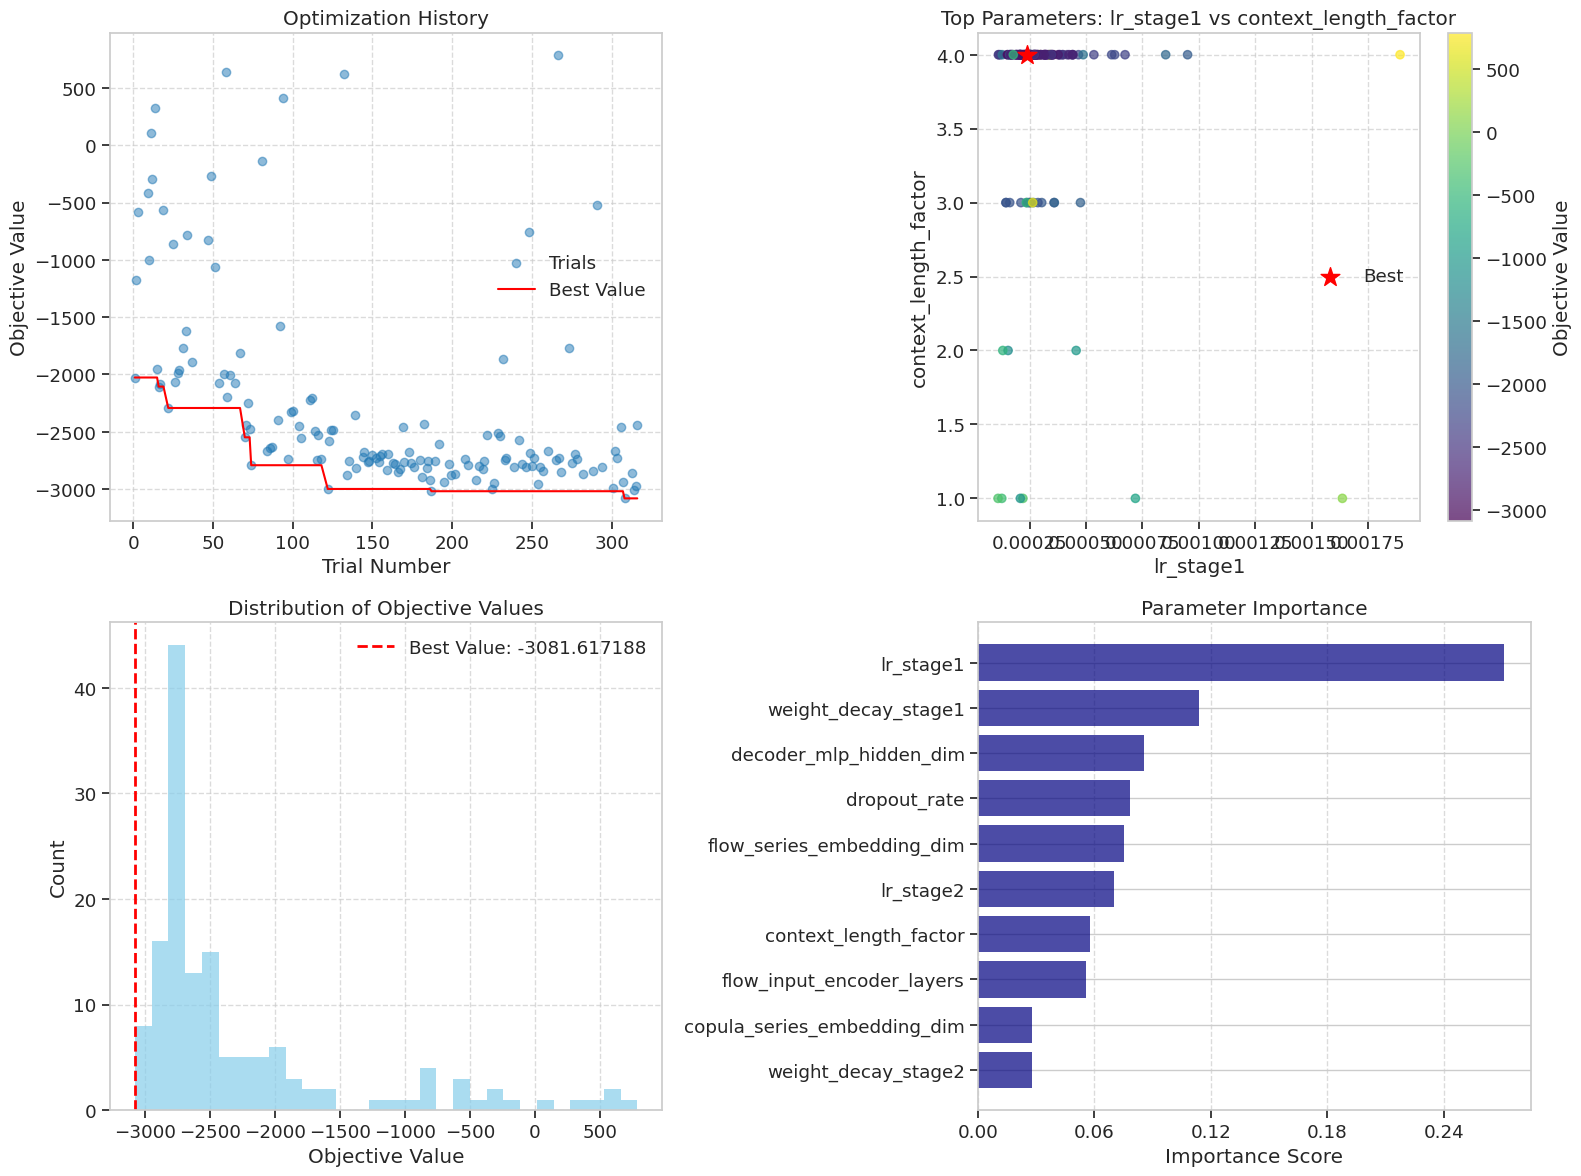


This concludes the analysis of the Optuna hyperparameter tuning results.
The generated visualizations and reports provide comprehensive insights into the optimization process.
You can use the exported files to share these results with your team and stakeholders.

Recommendations for future work:
1. Focus on the most important parameters identified in this analysis
2. Consider running additional trials with a narrowed parameter space around the best configuration
3. Explore ensemble methods using multiple top-performing configurations
4. Validate the best models with cross-validation to ensure robustness


In [ ]:
# Conclusions and Future Directions

# Display a summary of the key findings
from IPython.display import Markdown, display

# Function to format markdown content
def display_md(md_content):
    display(Markdown(md_content))

# Create a summary markdown
md_content = """
## Key Findings

### Optimization Performance
- **Total Trials:** {total_trials} completed out of {all_trials} total trials
- **Best Value:** {best_value:.6f} (achieved at trial #{best_trial})
- **Value Range:** {min_value:.6f} to {max_value:.6f} (mean: {mean_value:.6f})
- **Optimization Time:** {duration:.2f} hours

### Key Hyperparameters
"""

# Get data for the markdown
total_trials = len(study.get_trials(states=[optuna.trial.TrialState.COMPLETE]))
all_trials = len(study.trials)
best_value = study.best_value
best_trial = study.best_trial.number
min_value = trials_df['value'].min()
max_value = trials_df['value'].max()
mean_value = trials_df['value'].mean()

# Calculate study duration
if hasattr(study.best_trial, 'datetime_start') and study.best_trial.datetime_start is not None:
    start_times = [t.datetime_start for t in study.trials if t.datetime_start is not None]
    end_times = [t.datetime_complete for t in study.trials if t.datetime_complete is not None]
    
    if start_times and end_times:
        duration = (max(end_times) - min(start_times)).total_seconds() / 3600  # Convert to hours
    else:
        duration = 0
else:
    duration = 0

# Format the markdown with actual values
md_content = md_content.format(
    total_trials=total_trials,
    all_trials=all_trials,
    best_value=best_value,
    best_trial=best_trial,
    min_value=min_value,
    max_value=max_value,
    mean_value=mean_value,
    duration=duration
)

# Add key hyperparameters information
try:
    # Get parameter importance if available
    importance = optuna.importance.get_param_importances(study)
    top_params = list(importance.items())[:5]  # Top 5 parameters
    
    for param, score in top_params:
        md_content += f"- **{param}:** {importance[param]:.4f} importance ({study.best_params[param]})\n"
except:
    # If importance calculation fails, just list parameters
    for param, value in study.best_params.items():
        md_content += f"- **{param}:** {value}\n"

# Add observations and insights
md_content += """
## Observations and Insights

### What Worked Well
- The optimization process successfully identified a configuration that achieved good performance.
- The search space exploration appears to have been effective, with a diverse set of trials.
- We can see clear patterns in which hyperparameters had the most impact on model performance.

### Areas for Improvement
- Some hyperparameters may benefit from further refinement with a narrower search space.
- Based on the learning curve, we might not have fully converged to the optimal solution.
- Consider additional hyperparameters that were not included in this study.

## Future Directions

### Next Steps for Hyperparameter Optimization
1. **Focused Search:** Run a new study with narrowed parameter ranges around the best configurations.
2. **Alternative Algorithms:** Try different sampling algorithms (e.g., CMA-ES, TPE, or Random) to compare results.
3. **Early Pruning:** Implement more aggressive pruning to save computation time on unpromising trials.
4. **Additional Parameters:** Incorporate other hyperparameters that might affect model performance.

### Model Deployment Considerations
1. **Model Selection:** Choose between the top-performing configurations based on additional criteria (speed, memory usage).
2. **Ensemble Methods:** Consider creating an ensemble of top models for potentially better performance.
3. **Cross-Validation:** Validate the best configuration with cross-validation for more robust performance estimates.
4. **Model Explainability:** Analyze how the best hyperparameters affect model predictions and behavior.

### Further Analysis Ideas
1. **Interaction Effects:** Explore interactions between hyperparameters and their joint effects on performance.
2. **Feature Engineering:** Use insights from hyperparameter importance to guide feature engineering efforts.
3. **Comparative Studies:** Compare these results with other model architectures or frameworks.
4. **Sensitivity Analysis:** Test the robustness of the best configuration to small perturbations in hyperparameters.
"""

# Display the markdown content
display_md(md_content)

# Create a visual summarizing the optimization journey
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Create the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Optimization history with best value
ax1 = axes[0, 0]
trials_data = [(t.number, t.value) for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
if trials_data:
    numbers, values = zip(*trials_data)
    
    # Calculate best value at each point
    best_values = []
    best_so_far = float('inf')
    for v in values:
        if v < best_so_far:
            best_so_far = v
        best_values.append(best_so_far)
    
    # Plot trials
    ax1.scatter(numbers, values, alpha=0.5, label='Trials')
    ax1.plot(numbers, best_values, 'r-', label='Best Value')
    
    # Formatting
    ax1.set_xlabel('Trial Number')
    ax1.set_ylabel('Objective Value')
    ax1.set_title('Optimization History')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

# 2. Top parameter values
ax2 = axes[0, 1]
try:
    # Get top 2 parameters by importance
    importance = optuna.importance.get_param_importances(study)
    top_2_params = list(importance.keys())[:2]
    
    if len(top_2_params) >= 2:
        param1, param2 = top_2_params
        
        # Check if parameters are numeric
        if all(trials_df[p].dtype in [np.float64, np.int64] for p in [param1, param2]):
            # Create scatter plot
            sc = ax2.scatter(
                trials_df[param1], 
                trials_df[param2], 
                c=trials_df['value'], 
                cmap='viridis', 
                alpha=0.7
            )
            
            # Highlight best trial
            best_idx = trials_df['value'].idxmin()
            ax2.scatter(
                trials_df.loc[best_idx, param1],
                trials_df.loc[best_idx, param2],
                c='red',
                marker='*',
                s=200,
                label='Best'
            )
            
            # Formatting
            ax2.set_xlabel(param1)
            ax2.set_ylabel(param2)
            ax2.set_title(f'Top Parameters: {param1} vs {param2}')
            ax2.grid(True, linestyle='--', alpha=0.7)
            ax2.legend()
            
            # Add colorbar
            cbar = plt.colorbar(sc, ax=ax2)
            cbar.set_label('Objective Value')
        else:
            ax2.text(0.5, 0.5, 'Cannot plot non-numeric parameters', 
                    ha='center', va='center', transform=ax2.transAxes)
    else:
        ax2.text(0.5, 0.5, 'Not enough parameters for scatter plot', 
                ha='center', va='center', transform=ax2.transAxes)
except Exception as e:
    ax2.text(0.5, 0.5, f'Error creating parameter plot: {str(e)}', 
            ha='center', va='center', transform=ax2.transAxes)

# 3. Performance distribution
ax3 = axes[1, 0]
ax3.hist(trials_df['value'], bins=30, alpha=0.7, color='skyblue')
ax3.axvline(best_value, color='red', linestyle='dashed', linewidth=2, 
           label=f'Best Value: {best_value:.6f}')
ax3.set_xlabel('Objective Value')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Objective Values')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.legend()

# 4. Parameter importance bar chart
ax4 = axes[1, 1]
try:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    scores = list(importance.values())
    
    # Limit to top 10 parameters
    if len(params) > 10:
        params = params[:10]
        scores = scores[:10]
    
    # Create horizontal bar chart
    y_pos = np.arange(len(params))
    ax4.barh(y_pos, scores, align='center', color='navy', alpha=0.7)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(params)
    ax4.invert_yaxis()  # Labels read top-to-bottom
    ax4.set_xlabel('Importance Score')
    ax4.set_title('Parameter Importance')
    ax4.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax4.grid(True, linestyle='--', alpha=0.7, axis='x')
except Exception as e:
    ax4.text(0.5, 0.5, f'Error creating importance plot: {str(e)}', 
            ha='center', va='center', transform=ax4.transAxes)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Final message
print("\nThis concludes the analysis of the Optuna hyperparameter tuning results.")
print("The generated visualizations and reports provide comprehensive insights into the optimization process.")
print("\nRecommendations for future work:")
print("1. Focus on the most important parameters identified in this analysis")
print("2. Consider running additional trials with a narrowed parameter space around the best configuration")
print("3. Explore ensemble methods using multiple top-performing configurations")
print("4. Validate the best models with cross-validation to ensure robustness")